# Entrenamiento arquitectura recurrente con espectrograma
-----
En este notebook se realiza el entrenamiento de la arquitectura Convolucional sin aplicar normalización, para el desarrollo del trabajo de grado titulado: "Clasificación de patologías cardiovasculares con máquinas de aprendizaje profundo a partir de señales ECG".


# Importando Librerías

In [1]:
import optuna
import plotly
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.utils.vis_utils import plot_model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, regularizers, initializers, callbacks
import random as python_random
from numpy.random import seed
np.random.seed(123)
tf.random.set_seed(11)
python_random.seed(123)
os.environ['PYTHONHASHSEED'] = '0'
from keras import backend as K
from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session
import tensorflow
import gc
from sklearn.metrics import confusion_matrix
import itertools
from keras.callbacks import ModelCheckpoint
import json


# Definiendo funciones

In [122]:
TAMANIO=60

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
def plot_confusion_matrix(cm, classes,ruta,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2. 
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.gcf().set_size_inches(6,5)
    plt.savefig(ruta,dpi=300)
    plt.show()
def codificacion(tamano,unico=True,numero=0):
    #Vector de unos
    if unico==True:
        Y_train=np.ones(tamano)*numero
    else:
        for i in range(0,5):
            if i==0:
                Y_train=np.ones(tamano)*i
            else:
                vectorUnos=np.ones(tamano)
                Y_train=np.insert(Y_train,len(Y_train),vectorUnos*i,axis=0)
    return Y_train

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it does something you should see a number as output

    # use the same config as you used to create the session
    config = tensorflow.compat.v1.ConfigProto()
    tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction = 1)
    tf.compat.v1.GPUOptions(visible_device_list = "0")
    set_session(tf.compat.v1.Session(config=config))

def load_data_test_cnn():
    # load your data using this function
    path='C:\\Users\jdani\\Documents\\TrabajoDeGrado\\BDConEspectrograma\\MatricesNumpyGuardadas_SN\\ECG_'
    ECG_Normal_Test=np.load(path+'Normal\\ECG_Normal_test.npy')
    ECG_SBR_Test=np.load(path+'SBR\\ECG_SBR_Original.npy')
    ECG_SBR_Test=ECG_SBR_Test[300:360,:,:,:]
    ECG_AFIB_Test=np.load(path+'AFIB\\ECG_AFIB_test.npy')
    ECG_STD_Test=np.load(path+'STD\\ECG_STD_test.npy')
    ECG_STE_Test=np.load(path+'STE\\ECG_STE_test.npy')

    filas_seleccionadas = np.random.choice(len(ECG_Normal_Test), size=TAMANIO, replace=False)
    ECG_Normal_Test = ECG_Normal_Test[filas_seleccionadas]
    filas_seleccionadas = np.random.choice(len(ECG_AFIB_Test), size=TAMANIO, replace=False)
    ECG_AFIB_Test = ECG_AFIB_Test[filas_seleccionadas]
    filas_seleccionadas = np.random.choice(len(ECG_STD_Test), size=TAMANIO, replace=False)
    ECG_STD_Test = ECG_STD_Test[filas_seleccionadas]
    filas_seleccionadas = np.random.choice(len(ECG_STE_Test), size=TAMANIO, replace=False)
    ECG_STE_Test = ECG_STE_Test[filas_seleccionadas]
    

    y_Normal_Test=codificacion(len(ECG_Normal_Test),True,0)
    y_SBR_Test=codificacion(len(ECG_SBR_Test),True,1)
    y_AFIB_Test=codificacion(len(ECG_AFIB_Test),True,2)
    y_STD_Test=codificacion(len(ECG_STD_Test),True,3)
    y_STE_Test=codificacion(len(ECG_STE_Test),True,4)

    #Generando X_train

    X_test=np.concatenate((ECG_Normal_Test,
                                ECG_SBR_Test,
                                ECG_AFIB_Test,
                                ECG_STE_Test,
                                ECG_STD_Test))

    Y_test=np.insert(y_Normal_Test,len(y_Normal_Test),y_SBR_Test,axis=0)
    Y_test=np.insert(Y_test,len(Y_test),y_AFIB_Test,axis=0)
    Y_test=np.insert(Y_test,len(Y_test),y_STD_Test,axis=0)
    Y_test=np.insert(Y_test,len(Y_test),y_STE_Test,axis=0)    

    print('Tamaño datos test: '+ str(X_test.shape))
    print('Tamaño etiquetas de test: '+str(Y_test.shape))   
    return X_test,Y_test
def load_data_cnn():
    path='C:\\Users\jdani\\Documents\\TrabajoDeGrado\\BDConEspectrograma\\MatricesNumpyGuardadas_SN\\ECG_'
    #importando patologias
    ECG_Normal_Original=np.load(path+'Normal\\ECG_Normal_Original.npy')
    ECG_SBR_Original=np.load(path+'SBR\\ECG_SBR_Original.npy')
    print(ECG_SBR_Original.shape)
    ECG_AFIB_Original=np.load(path+'AFIB\\ECG_AFIB_Original.npy')
    ECG_STD_Original=np.load(path+'STD\\ECG_STD_Original.npy')
    ECG_STE_Original=np.load(path+'STE\\ECG_STE_Original.npy')
        
    # partiendo base de datos y generando labels
    ECG_Normal_Train=ECG_Normal_Original[:,:,:]
    y_Normal_Train=codificacion(len(ECG_Normal_Train),True,0)
    ECG_SBR_Train=ECG_SBR_Original[:300,:,:]
    y_SBR_Train=codificacion(len(ECG_SBR_Train),True,1)
    ECG_AFIB_Train=ECG_AFIB_Original[:,:,:]
    y_AFIB_Train=codificacion(len(ECG_AFIB_Train),True,2)
    ECG_STD_Train=ECG_STD_Original[:,:,:]
    y_STD_Train=codificacion(len(ECG_STD_Train),True,3)
    ECG_STE_Train=ECG_STE_Original[:,:,:]
    y_STE_Train=codificacion(len(ECG_STE_Train),True,4)

    #Generando Y
    Y_train=np.insert(y_Normal_Train,len(y_Normal_Train),y_SBR_Train,axis=0)
    Y_train=np.insert(Y_train,len(Y_train),y_AFIB_Train,axis=0)
    Y_train=np.insert(Y_train,len(Y_train),y_STD_Train,axis=0)
    Y_train=np.insert(Y_train,len(Y_train),y_STE_Train,axis=0)


    #Generando X_train

    X_train=np.concatenate((ECG_Normal_Train,
                                ECG_SBR_Train,
                                ECG_AFIB_Train,
                                ECG_STE_Train,
                                ECG_STD_Train))
    print('Tamaño datos entrenamiento: '+ str(X_train.shape))
    print('Tamaño etiquetas de entrenamiento: '+str(Y_train.shape))
    
    X_test,Y_test=load_data_test_cnn()
    
    Y_train= keras.utils.to_categorical(Y_train)
    Y_test= keras.utils.to_categorical(Y_test)
    return X_train,Y_train,X_test,Y_test

In [3]:
# X_train,Y_train,X_test,Y_test=load_data_cnn()
# X_train
# X_test

# print()
# print()
# print(X_train.shape)
# print(Y_train.shape)
# print(X_test.shape)
# print(Y_test.shape)

# Creando modelo para optimización con Optuna

In [3]:
#Definiendo constantes
EPOCAS=30
ciclo=0
mejores={}
def modelo_CNN(trial):
    # n_hidden=trial.suggest_int('n_hidden',256,1024)
    drop_path_rate = trial.suggest_float("drop_path_rate", 0.5, 0.8, step=0.1)
    # n_hidden=trial.suggest_int('n_hidden',128,1024)
    n_hidden = trial.suggest_categorical("n_hidden", [128,256])
    # Regularización L2
    input_shape = (4000, 51, 241, 2)
    ModelCNN2D=keras.models.Sequential()
    ModelCNN2D.add(keras.layers.Conv2D(32,(3,3),padding="same",activation="relu",input_shape=input_shape[1:]))
    ModelCNN2D.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    ModelCNN2D.add(keras.layers.Conv2D(64,(3,3),padding="same",activation="relu"))
    ModelCNN2D.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    ModelCNN2D.add(keras.layers.Flatten())
    ModelCNN2D.add(keras.layers.Dense(n_hidden,activation="relu",activity_regularizer=regularizers.L1L2(1e-3)))
    ModelCNN2D.add(keras.layers.Dropout(drop_path_rate))
    ModelCNN2D.add(keras.layers.Dense(5,activation="softmax"))
    ModelCNN2D.summary()
    
    return ModelCNN2D

def create_optimizer_CNN(trial):
    # We optimize the choice of optimizers as well as their parameters.
    kwargs = {}
    # optimizer_options = ["RMSprop", "Adam", "SGD"]
    optimizer_selected = "Adam"
    # optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)
    if optimizer_selected == "RMSprop":
        kwargs["learning_rate"] = trial.suggest_float(
            "rmsprop_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["decay"] = trial.suggest_float("rmsprop_decay", 0.85, 0.99)
        kwargs["momentum"] = trial.suggest_float("rmsprop_momentum", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "Adam":
        kwargs["learning_rate"] = trial.suggest_float("adam_learning_rate", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "SGD":
        kwargs["learning_rate"] = trial.suggest_float(
            "sgd_opt_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["momentum"] = trial.suggest_float("sgd_opt_momentum", 1e-5, 1e-1, log=True)

    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    return optimizer

def learn_CNN(trial,model, optimizer, X,Y,X_test,Y_test):
    global ciclo
    global mejores
    batches=trial.suggest_int('batches',64,256)
    # val_split=trial.suggest_float('val_split',0.1,0.2,step=0.05)
    model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy',tf.keras.metrics.AUC(),f1])
    Stop = callbacks.EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=10)
    ruta_modelo='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\ModelosCheckpointsOptuna\\SN\\'
    ruta_modelo_trial=ruta_modelo+'mejor_modelo_trial'+str(ciclo)+'.h5'
    Checkpoint = ModelCheckpoint(ruta_modelo_trial, monitor="val_accuracy", save_best_only=True, mode="max")
    history_CNN=model.fit(X,Y,verbose=1,validation_data=(X_test,Y_test),epochs=EPOCAS,batch_size=batches,callbacks=[Stop, Checkpoint])
    ciclo+=1
    mejores['trial '+str(ciclo)]=Checkpoint.best
    
    #Guardando historiales
    with open(ruta_modelo+'historial_Modelo_CNN_trial'+str(ciclo)+'.json', 'w') as f:
        json.dump(history_CNN.history, f)
    
    reset_keras()
    gc.collect()
    return history_CNN.history['val_accuracy'][-1]

def objective_CNN(trial):
    ##Datos
    X_train,y_train,X_test,y_test=load_data_cnn()
    
    # Clear clutter from previous session graphs.
    # keras.backend.clear_session()
    #Contruyendo modelo y optimizador
    model=modelo_CNN(trial)
    optimizer=create_optimizer_CNN(trial)
    
    #Entrenando y validando
    loss=learn_CNN(trial,model,optimizer,X_train,y_train,X_test,y_test)
    # reset_keras()
    return loss

In [5]:
study_CNN=optuna.create_study(direction="maximize") #Para minimizar la función de pérdida

[I 2023-04-08 13:25:15,752] A new study created in memory with name: no-name-0074e5e5-4d08-4b2f-bda3-c4b11fcc8155


In [6]:
study_CNN.optimize(objective_CNN,n_trials=50)

(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 13:29:43,435] Trial 0 finished with value: 0.6899999976158142 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 256, 'adam_learning_rate': 0.01234073970939693, 'batches': 79}. Best is trial 0 with value: 0.6899999976158142.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 13:33:59,936] Trial 1 finished with value: 0.6700000166893005 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 256, 'adam_learning_rate': 0.00019546427930175838, 'batches': 76}. Best is trial 0 with value: 0.6899999976158142.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 13:37:30,105] Trial 2 finished with value: 0.7400000095367432 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 128, 'adam_learning_rate': 0.002881098938212148, 'batches': 241}. Best is trial 2 with value: 0.7400000095367432.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 13:39:06,790] Trial 3 finished with value: 0.20000000298023224 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 256, 'adam_learning_rate': 0.04476135976583298, 'batches': 142}. Best is trial 2 with value: 0.7400000095367432.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 13:40:45,552] Trial 4 finished with value: 0.20000000298023224 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 128, 'adam_learning_rate': 0.030652025100244243, 'batches': 71}. Best is trial 2 with value: 0.7400000095367432.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 13:44:43,456] Trial 5 finished with value: 0.6333333253860474 and parameters: {'drop_path_rate': 0.7, 'n_hidden': 256, 'adam_learning_rate': 0.00017886840558952558, 'batches': 146}. Best is trial 2 with value: 0.7400000095367432.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 13:48:24,959] Trial 6 finished with value: 0.43666666746139526 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 256, 'adam_learning_rate': 7.624214587628747e-05, 'batches': 223}. Best is trial 2 with value: 0.7400000095367432.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 13:52:05,254] Trial 7 finished with value: 0.6866666674613953 and parameters: {'drop_path_rate': 0.8, 'n_hidden': 128, 'adam_learning_rate': 0.010512827555503748, 'batches': 149}. Best is trial 2 with value: 0.7400000095367432.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 13:55:59,305] Trial 8 finished with value: 0.6200000047683716 and parameters: {'drop_path_rate': 0.7, 'n_hidden': 256, 'adam_learning_rate': 0.00017981525241386224, 'batches': 178}. Best is trial 2 with value: 0.7400000095367432.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 14:00:10,110] Trial 9 finished with value: 0.7900000214576721 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 128, 'adam_learning_rate': 0.00013869121017517008, 'batches': 66}. Best is trial 9 with value: 0.7900000214576721.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 14:04:02,457] Trial 10 finished with value: 0.18333333730697632 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 128, 'adam_learning_rate': 1.1516262206912542e-05, 'batches': 105}. Best is trial 9 with value: 0.7900000214576721.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 14:07:28,381] Trial 11 finished with value: 0.7266666889190674 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 128, 'adam_learning_rate': 0.0018917347793555087, 'batches': 246}. Best is trial 9 with value: 0.7900000214576721.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 14:10:58,488] Trial 12 finished with value: 0.5633333325386047 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 128, 'adam_learning_rate': 0.0014140978818694065, 'batches': 199}. Best is trial 9 with value: 0.7900000214576721.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 14:14:21,645] Trial 13 finished with value: 0.7766666412353516 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 128, 'adam_learning_rate': 0.0032615972515673886, 'batches': 252}. Best is trial 9 with value: 0.7900000214576721.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 14:18:06,944] Trial 14 finished with value: 0.6033333539962769 and parameters: {'drop_path_rate': 0.8, 'n_hidden': 128, 'adam_learning_rate': 0.0006046446340915092, 'batches': 114}. Best is trial 9 with value: 0.7900000214576721.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 14:21:32,118] Trial 15 finished with value: 0.70333331823349 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 128, 'adam_learning_rate': 0.007707285818572541, 'batches': 199}. Best is trial 9 with value: 0.7900000214576721.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 14:25:25,388] Trial 16 finished with value: 0.7633333206176758 and parameters: {'drop_path_rate': 0.7, 'n_hidden': 128, 'adam_learning_rate': 0.0004929217264904386, 'batches': 116}. Best is trial 9 with value: 0.7900000214576721.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 14:29:00,124] Trial 17 finished with value: 0.5199999809265137 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 128, 'adam_learning_rate': 0.005195221347505012, 'batches': 174}. Best is trial 9 with value: 0.7900000214576721.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 14:30:26,304] Trial 18 finished with value: 0.20000000298023224 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 128, 'adam_learning_rate': 0.06702449329419033, 'batches': 215}. Best is trial 9 with value: 0.7900000214576721.


3709
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 fl

[I 2023-04-08 14:34:18,471] Trial 19 finished with value: 0.6966666579246521 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 128, 'adam_learning_rate': 0.0009138006104563638, 'batches': 99}. Best is trial 9 with value: 0.7900000214576721.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 14:37:57,114] Trial 20 finished with value: 0.6233333349227905 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 128, 'adam_learning_rate': 0.002982628609614398, 'batches': 169}. Best is trial 9 with value: 0.7900000214576721.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 14:41:59,788] Trial 21 finished with value: 0.6933333277702332 and parameters: {'drop_path_rate': 0.7, 'n_hidden': 128, 'adam_learning_rate': 0.0006092513940547314, 'batches': 123}. Best is trial 9 with value: 0.7900000214576721.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 14:45:52,540] Trial 22 finished with value: 0.6733333468437195 and parameters: {'drop_path_rate': 0.7, 'n_hidden': 128, 'adam_learning_rate': 0.0003906925359211794, 'batches': 92}. Best is trial 9 with value: 0.7900000214576721.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 14:49:34,505] Trial 23 finished with value: 0.6866666674613953 and parameters: {'drop_path_rate': 0.8, 'n_hidden': 128, 'adam_learning_rate': 0.0011904268621900564, 'batches': 128}. Best is trial 9 with value: 0.7900000214576721.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 14:53:30,848] Trial 24 finished with value: 0.34333333373069763 and parameters: {'drop_path_rate': 0.7, 'n_hidden': 128, 'adam_learning_rate': 5.3349907460323296e-05, 'batches': 89}. Best is trial 9 with value: 0.7900000214576721.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 14:57:12,953] Trial 25 finished with value: 0.5600000023841858 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 128, 'adam_learning_rate': 0.003556487795126592, 'batches': 134}. Best is trial 9 with value: 0.7900000214576721.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 15:00:52,741] Trial 26 finished with value: 0.6433333158493042 and parameters: {'drop_path_rate': 0.7, 'n_hidden': 128, 'adam_learning_rate': 0.0016154442131688115, 'batches': 159}. Best is trial 9 with value: 0.7900000214576721.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 15:04:59,330] Trial 27 finished with value: 0.7433333396911621 and parameters: {'drop_path_rate': 0.8, 'n_hidden': 128, 'adam_learning_rate': 0.0006359451281567573, 'batches': 67}. Best is trial 9 with value: 0.7900000214576721.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 15:08:51,501] Trial 28 finished with value: 0.70333331823349 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 128, 'adam_learning_rate': 0.0003416999108375375, 'batches': 105}. Best is trial 9 with value: 0.7900000214576721.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 15:12:54,219] Trial 29 finished with value: 0.6133333444595337 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 256, 'adam_learning_rate': 0.005662898185329578, 'batches': 85}. Best is trial 9 with value: 0.7900000214576721.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 15:16:15,618] Trial 30 finished with value: 0.54666668176651 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 128, 'adam_learning_rate': 0.016201333825310197, 'batches': 256}. Best is trial 9 with value: 0.7900000214576721.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 15:20:17,911] Trial 31 finished with value: 0.6766666769981384 and parameters: {'drop_path_rate': 0.8, 'n_hidden': 128, 'adam_learning_rate': 0.0008550361809154995, 'batches': 65}. Best is trial 9 with value: 0.7900000214576721.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 15:24:13,796] Trial 32 finished with value: 0.6133333444595337 and parameters: {'drop_path_rate': 0.8, 'n_hidden': 128, 'adam_learning_rate': 0.0003519540716625852, 'batches': 80}. Best is trial 9 with value: 0.7900000214576721.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 15:28:09,164] Trial 33 finished with value: 0.5600000023841858 and parameters: {'drop_path_rate': 0.8, 'n_hidden': 128, 'adam_learning_rate': 0.0030324756717316093, 'batches': 64}. Best is trial 9 with value: 0.7900000214576721.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 15:32:15,030] Trial 34 finished with value: 0.7233333587646484 and parameters: {'drop_path_rate': 0.7, 'n_hidden': 256, 'adam_learning_rate': 0.001718031598972485, 'batches': 82}. Best is trial 9 with value: 0.7900000214576721.


3692
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 fl

[I 2023-04-08 15:36:03,722] Trial 35 finished with value: 0.6466666460037231 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 128, 'adam_learning_rate': 0.0005870612967248408, 'batches': 115}. Best is trial 9 with value: 0.7900000214576721.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 15:40:02,872] Trial 36 finished with value: 0.5899999737739563 and parameters: {'drop_path_rate': 0.8, 'n_hidden': 128, 'adam_learning_rate': 0.00021916878612847785, 'batches': 75}. Best is trial 9 with value: 0.7900000214576721.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 15:43:50,700] Trial 37 finished with value: 0.5733333230018616 and parameters: {'drop_path_rate': 0.7, 'n_hidden': 256, 'adam_learning_rate': 0.00011338968173144069, 'batches': 191}. Best is trial 9 with value: 0.7900000214576721.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 15:47:13,134] Trial 38 finished with value: 0.7333333492279053 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 128, 'adam_learning_rate': 0.0178598191129159, 'batches': 224}. Best is trial 9 with value: 0.7900000214576721.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 15:51:13,607] Trial 39 finished with value: 0.6733333468437195 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 256, 'adam_learning_rate': 0.0020025646745793725, 'batches': 98}. Best is trial 9 with value: 0.7900000214576721.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 15:55:11,860] Trial 40 finished with value: 0.7099999785423279 and parameters: {'drop_path_rate': 0.7, 'n_hidden': 128, 'adam_learning_rate': 0.0009837781160525522, 'batches': 72}. Best is trial 9 with value: 0.7900000214576721.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 15:58:34,588] Trial 41 finished with value: 0.6433333158493042 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 128, 'adam_learning_rate': 0.003724806359469567, 'batches': 240}. Best is trial 9 with value: 0.7900000214576721.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 16:01:59,191] Trial 42 finished with value: 0.6733333468437195 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 128, 'adam_learning_rate': 0.0022523469212445725, 'batches': 234}. Best is trial 9 with value: 0.7900000214576721.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 16:05:21,144] Trial 43 finished with value: 0.5533333420753479 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 128, 'adam_learning_rate': 0.010142823094794863, 'batches': 249}. Best is trial 9 with value: 0.7900000214576721.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 16:08:49,591] Trial 44 finished with value: 0.6766666769981384 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 128, 'adam_learning_rate': 0.0013959930512126555, 'batches': 228}. Best is trial 9 with value: 0.7900000214576721.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 16:12:15,965] Trial 45 finished with value: 0.6933333277702332 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 128, 'adam_learning_rate': 0.005834891429588627, 'batches': 210}. Best is trial 9 with value: 0.7900000214576721.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 16:16:12,393] Trial 46 finished with value: 0.7066666483879089 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 256, 'adam_learning_rate': 0.0002519999158302294, 'batches': 142}. Best is trial 9 with value: 0.7900000214576721.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 16:19:52,903] Trial 47 finished with value: 0.7200000286102295 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 128, 'adam_learning_rate': 0.0005839243210477756, 'batches': 158}. Best is trial 9 with value: 0.7900000214576721.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 16:23:16,801] Trial 48 finished with value: 0.7166666388511658 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 128, 'adam_learning_rate': 0.002512737250297769, 'batches': 254}. Best is trial 9 with value: 0.7900000214576721.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 16:26:44,953] Trial 49 finished with value: 0.47999998927116394 and parameters: {'drop_path_rate': 0.8, 'n_hidden': 128, 'adam_learning_rate': 0.00016382803462392255, 'batches': 240}. Best is trial 9 with value: 0.7900000214576721.


# Graficas obetenidas de la optimización

In [7]:
# import plotly.io as pio
fig = optuna.visualization.plot_param_importances(study_CNN)
# pio.write_image(fig, 'nombre_del_archivo.png')
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 500,
    'width': 1000,
    'scale':4 # Multiply title/legend/axis/canvas sizes by this factor
  }
}
fig.update_layout(title={
                    'text':"Importancia de los hiperparámetros en la optimización",
                    'x':0.5, #Centrar el título horizontalmente
                    'y':0.90, #Posicionar el título en la parte superior
                    'xanchor': 'center',
                    'yanchor': 'top'})
fig.show( config=config)

In [8]:
fig = optuna.visualization.plot_contour(study_CNN, params=["adam_learning_rate", "batches"],target_name="Val_accuracy")
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 500,
    'width': 1000,
    'scale':4 # Multiply title/legend/axis/canvas sizes by this factor
  }
}
fig.update_layout(title={
                    'text':"Gráfico de líneas de contorno",
                    'x':0.5, #Centrar el título horizontalmente
                    'y':0.90, #Posicionar el título en la parte superior
                    'xanchor': 'center',
                    'yanchor': 'top'})
fig.show( config=config)

In [9]:
fig = optuna.visualization.plot_optimization_history(study_CNN,target_name="Val_accuracy")
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 500,
    'width': 1000,
    'scale':4 # Multiply title/legend/axis/canvas sizes by this factor
  }
}
fig.update_layout(title={
                    'text': "Gráfico de historial de optimización",
                    'x':0.5, #Centrar el título horizontalmente
                    'y':0.90, #Posicionar el título en la parte superior
                    'xanchor': 'center',
                    'yanchor': 'top'})

fig.show( config=config)

In [10]:
#Ubicacion del mejor modelo entrenado
max_key = None
max_value = float('-inf')

for key, value in mejores.items():
    if value > max_value:
        max_key = key
        max_value = value

print(f"La clave con el valor más alto es '{max_key}' con valor {max_value}\n")

#Extrayendo hiperparametros del mejor trial
print("Number of finished trials: ", len(study_CNN.trials))
print("Number of BEST trials: ", study_CNN.best_trial.number)
print("Best trial:")
trial = study_CNN.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

La clave con el valor más alto es 'trial 14' con valor 0.8399999737739563

Number of finished trials:  50
Number of BEST trials:  9
Best trial:
  Value:  0.7900000214576721
  Params: 
    drop_path_rate: 0.5
    n_hidden: 128
    adam_learning_rate: 0.00013869121017517008
    batches: 66


# Mejor modelo Optuna por checkpoint

Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)

10/10 [==============================] - 0s 9ms/step
[[9.9424642e-01 8.8572694e-04 3.7380079e-05 3.6300034e-03 1.2005585e-03]
 [7.8446048e-01 7.4264174e-03 4.6049315e-02 5.9192982e-02 1.0287075e-01]
 [4.0912658e-01 4.4858814e-04 2.4351990e-01 4.2709090e-02 3.0419582e-01]
 ...
 [1.5390639e-02 4.1436360e-05 2.4177579e-03 2.3793358e-02 9.5835680e-01]
 [2.6200160e-03 4.8075732e-10 1.9704756e-05 1.0276356e-03 9.9633265e-01]
 [1.0368693e-02 2.6526184e-06 4.7426918e-04 6.2409798e-03 9.8291343e-01]]
Normalized confusion matrix
[[0.7  0.   0.1  0.07 0.13]
 [0.   1.   0.   0.   0.  ]
 [0.12 0.   0.88 0.   0.  ]
 [0.25 0.   0.18 0.32 0.25]
 [0.   0.   0.   0.   1.  ]]


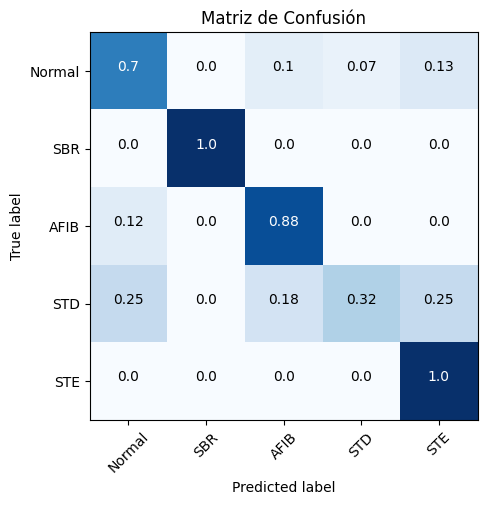

In [126]:

# cargar datos de prueba
data_test, labels_test = load_data_test_cnn()

# Imprimiendo tamaño de test
print()

# cargar modelo previamente entrenado
model_file = 'C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\ModelosCheckpointsOptuna\\SN\\mejor_modelo_trial'
modelo='13'
Best_Model_CNN = keras.models.load_model(model_file+modelo+'.h5',custom_objects={'f1': f1})
# hacer la predicción
y_prediction = Best_Model_CNN.predict(data_test)
print(y_prediction)
rounded_predictions=np.argmax(y_prediction,axis=1)

# obtener matriz de confusión y graficarla
cm = confusion_matrix(y_true=labels_test, y_pred=rounded_predictions)
cm_plot_labels = ['Normal','SBR','AFIB','STD','STE']
ruta='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\MatricesDeConfusion\\SN\\'
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, ruta=ruta+'MatrizMejorModeloOptuna_SN.png',title='Matriz de Confusión',normalize=True)

# Entrenando modelo con los mejores Hiperparámetros

In [9]:
def create_model_cnn():
    input_shape = (1, 241, 102)
    ModelCNN=keras.models.Sequential()

    input_shape = (4000, 51, 241, 2)
    ModelCNN2D=keras.models.Sequential()
    ModelCNN2D.add(keras.layers.Conv2D(32,(3,3),padding="same",activation="relu",input_shape=input_shape[1:]))
    ModelCNN2D.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    ModelCNN2D.add(keras.layers.Conv2D(64,(3,3),padding="same",activation="relu"))
    ModelCNN2D.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    ModelCNN2D.add(keras.layers.Flatten())
    ModelCNN2D.add(keras.layers.Dense(128,activation="relu"))
    ModelCNN2D.add(keras.layers.Dropout(0.5))
    ModelCNN2D.add(keras.layers.Dense(5,activation="softmax"))
    ModelCNN2D.summary()
    
    return ModelCNN2D


In [12]:
K.clear_session()
reset_keras()
data_test, labels_test_OHE,data_val, labels_val_OHE = load_data_cnn()
# Entrenando y guardando el modelo
Best_Hiper_ModelCNN=create_model_cnn()
opt = optimizers.Adam(learning_rate=0.00013869121017517008)
Best_Hiper_ModelCNN.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy',tf.keras.metrics.AUC(),f1])
ruta_modelo='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\ModelosCheckpointsMejoresHiperparametros\\SN\\'
ruta_modelo_trial=ruta_modelo+'mejor_modelo_CNN_SN.h5'
Checkpoint = ModelCheckpoint(ruta_modelo_trial, monitor="val_accuracy", save_best_only=True, mode="max")
history=Best_Hiper_ModelCNN.fit(data_test,labels_test_OHE,verbose=1,epochs=50,batch_size=66,validation_data=(data_val,labels_val_OHE),callbacks=[Checkpoint])

4858
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 

# Graficas modelo con los mejores hiperparámetros

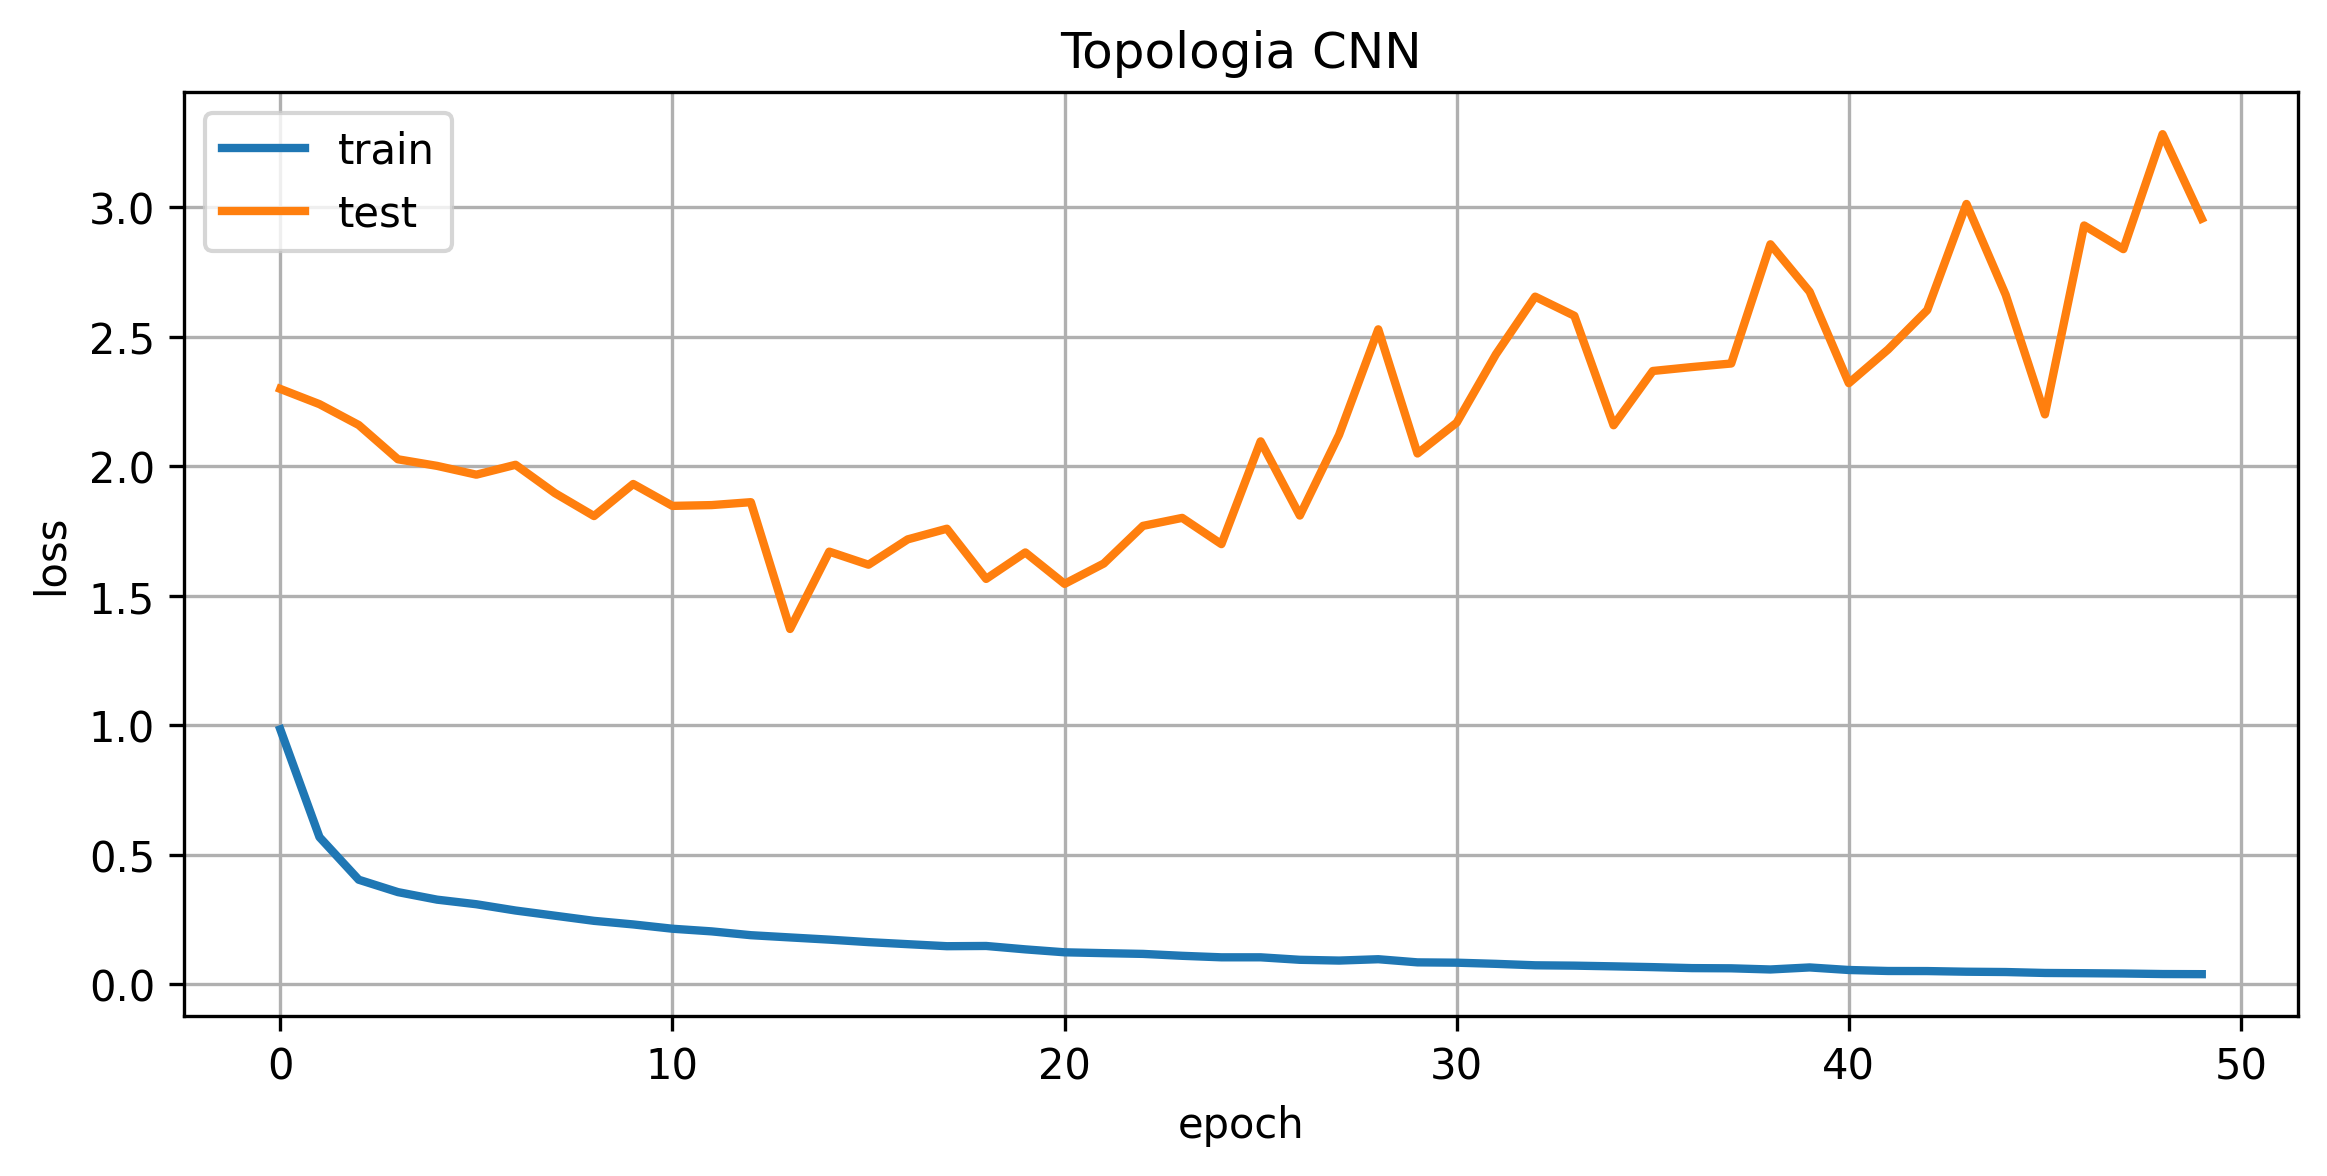

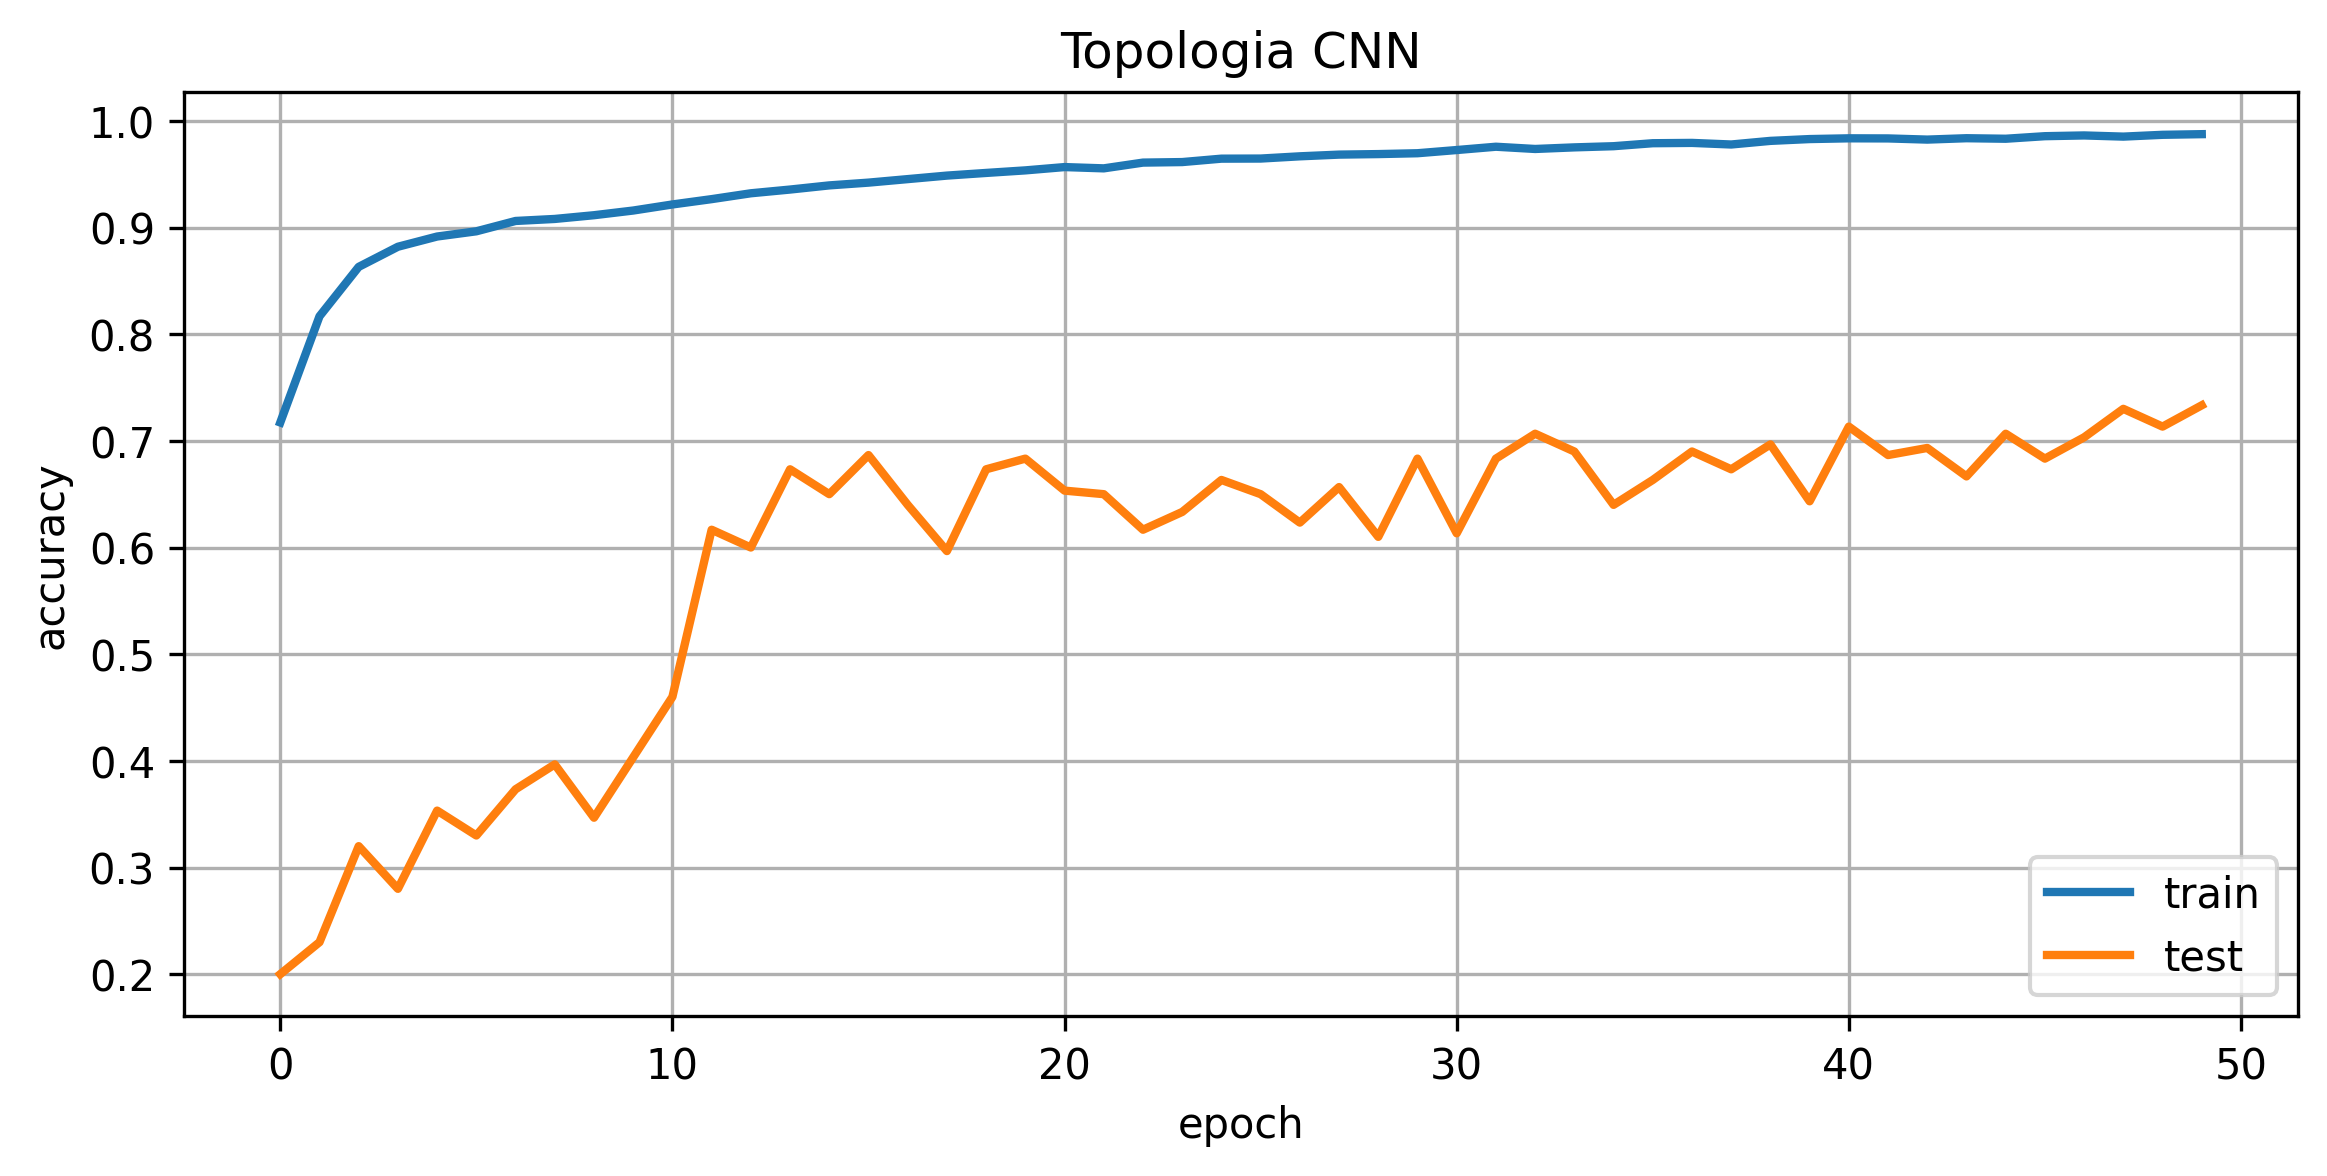

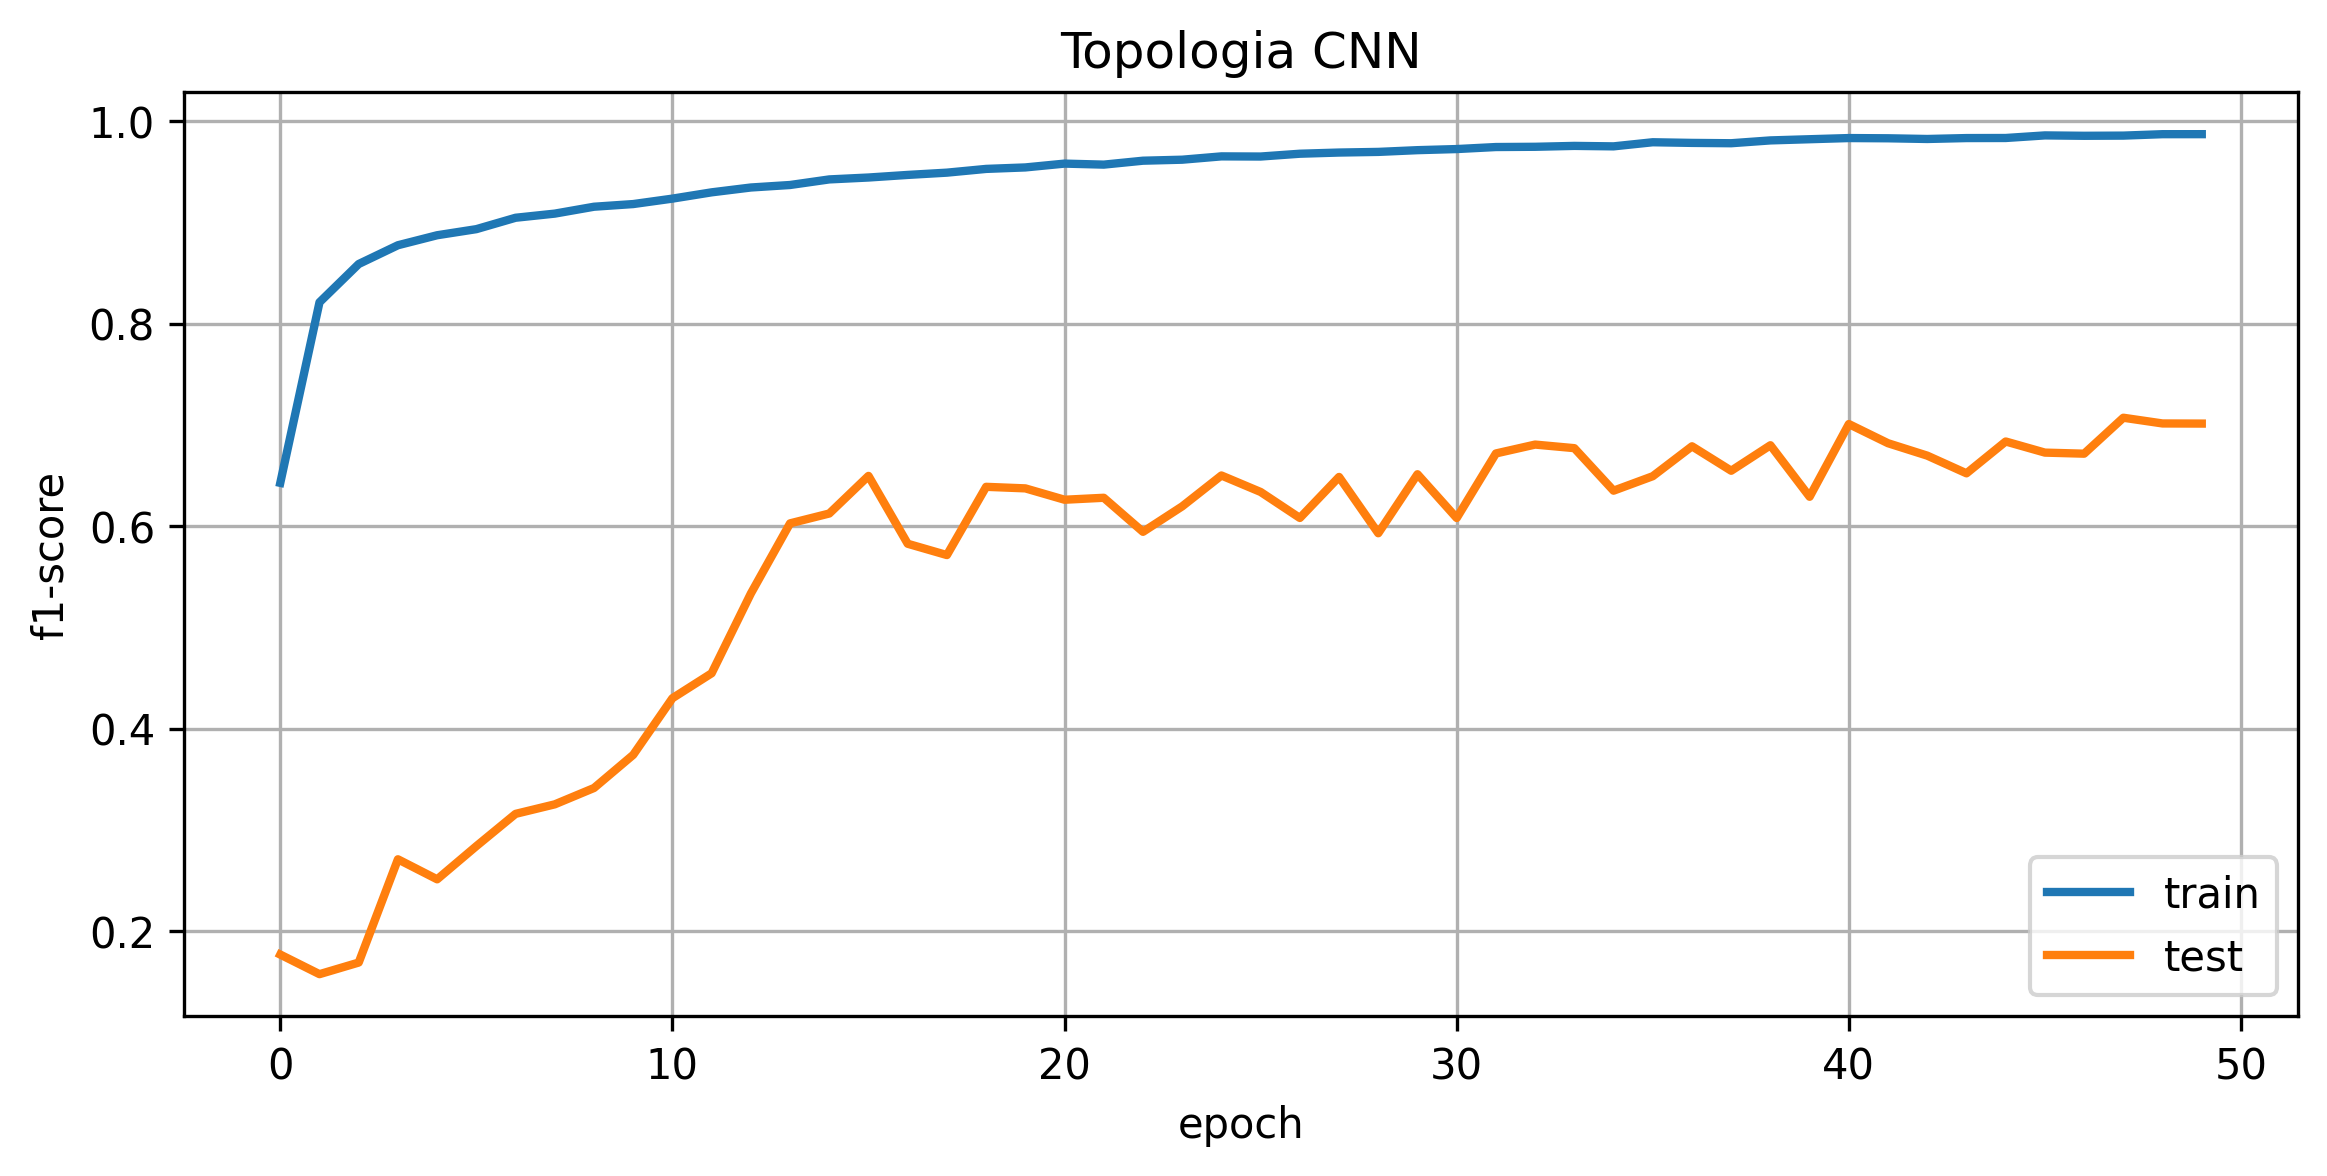

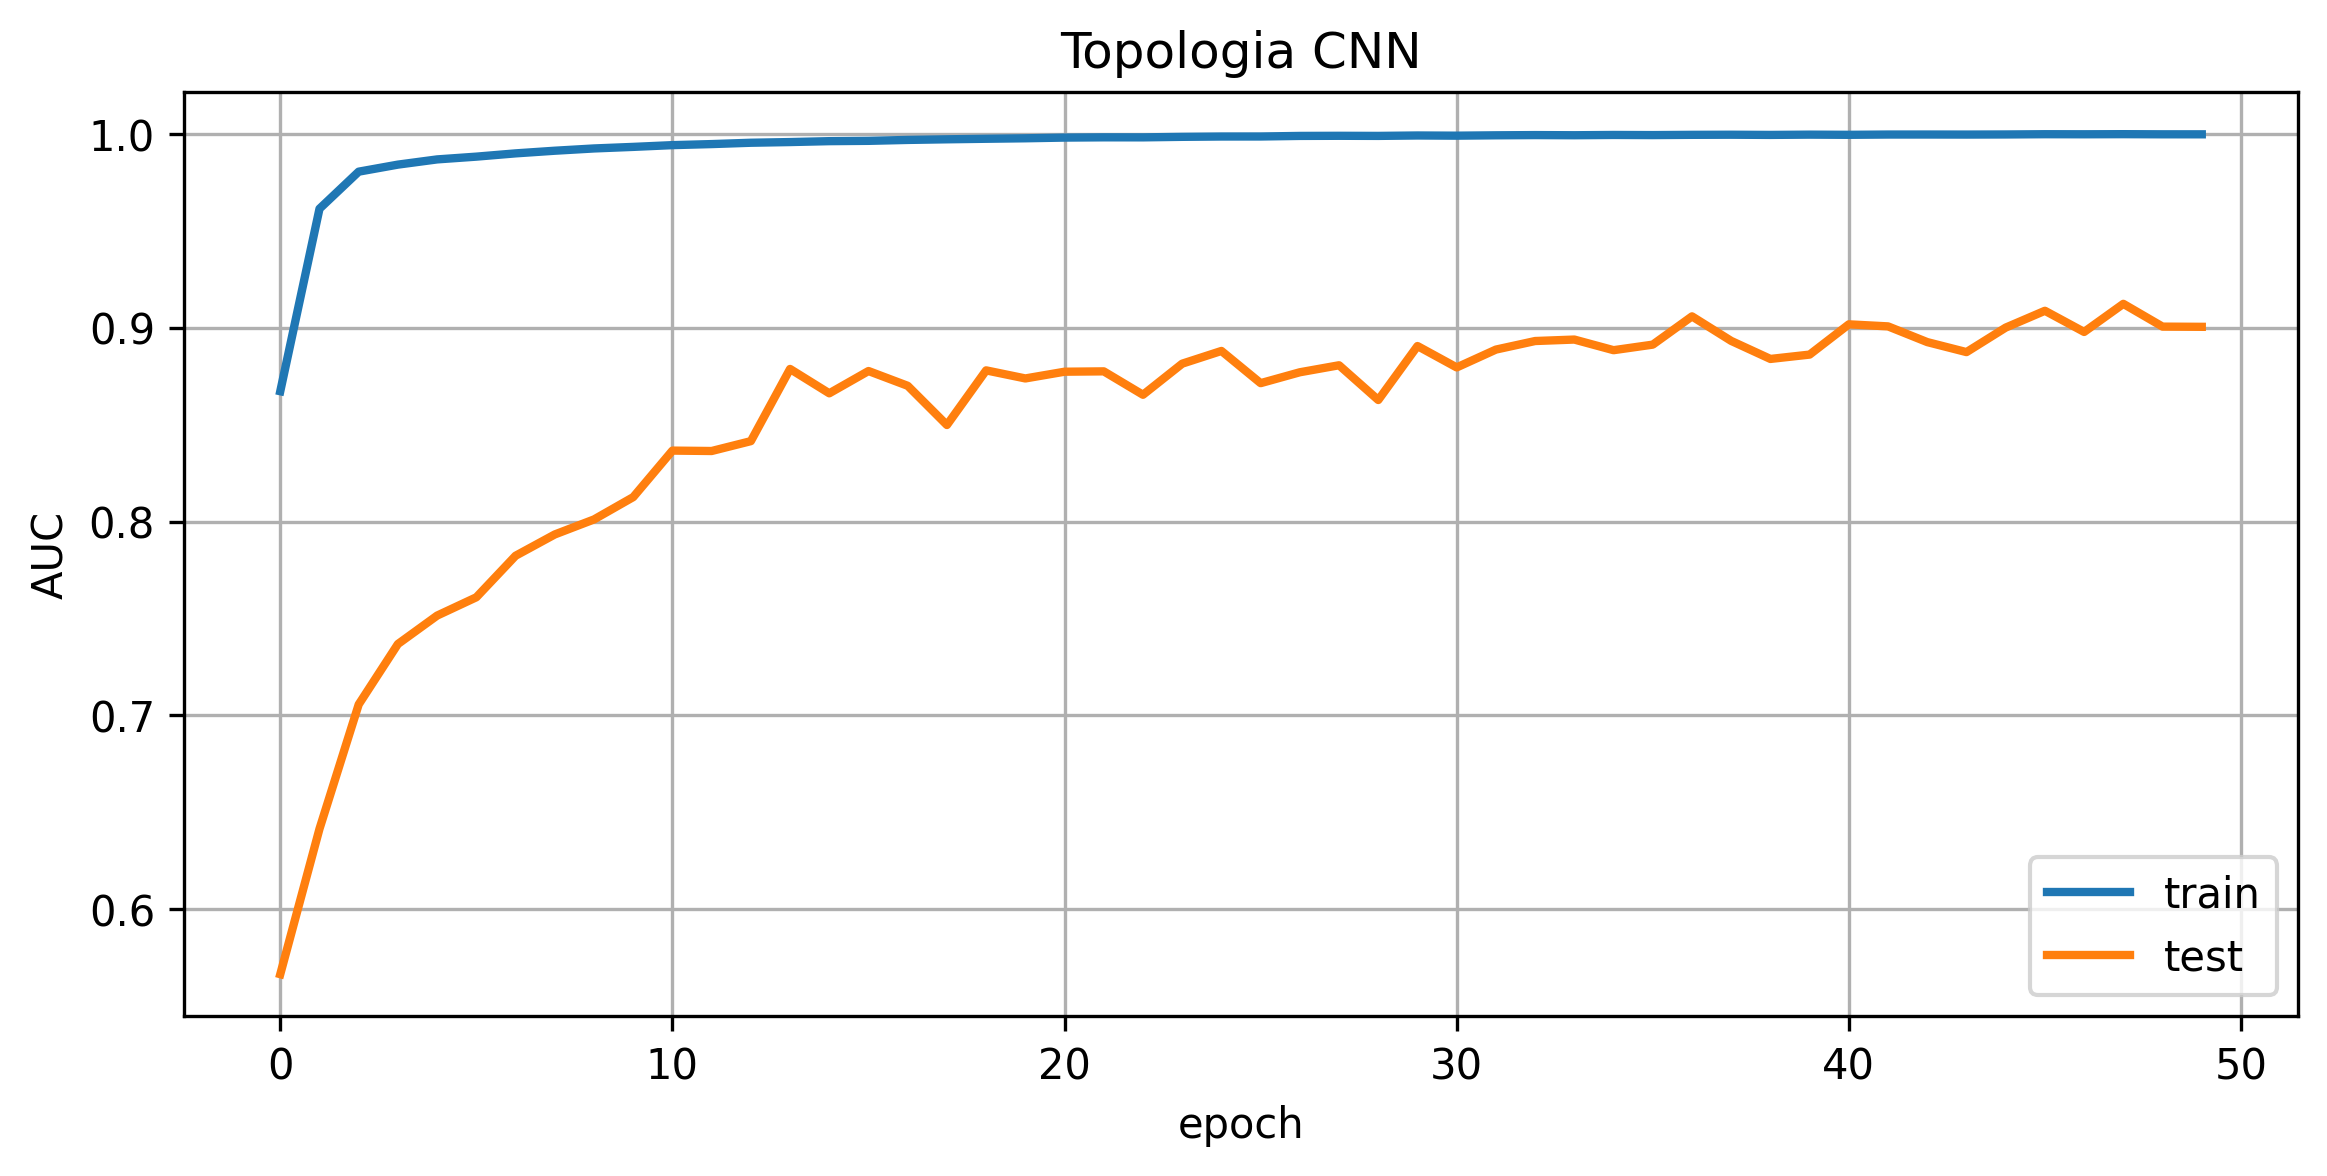

In [13]:
plt.figure(figsize=(20, 4),dpi=300)
plt.subplot(1,2,1)
plt.plot(history.history['loss'], linewidth=2, )
plt.plot(history.history['val_loss'], linewidth=2)
plt.title('Topologia CNN')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'])
plt.grid()
plt.show()

plt.figure(figsize=(20, 4),dpi=300)
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], linewidth=2,)
plt.plot(history.history['val_accuracy'], linewidth=2,)
plt.title('Topologia CNN')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'])
plt.grid()
plt.show()

plt.figure(figsize=(20, 4),dpi=300)
plt.subplot(1,2,2)
plt.plot(history.history['f1'], linewidth=2,)
plt.plot(history.history['val_f1'], linewidth=2,)
plt.title('Topologia CNN')
plt.ylabel('f1-score')
plt.xlabel('epoch')
plt.legend(['train','test'])
plt.grid()
plt.show()

plt.figure(figsize=(20, 4),dpi=300)
plt.subplot(1,2,2)
plt.plot(history.history['auc'], linewidth=2,)
plt.plot(history.history['val_auc'], linewidth=2,)
plt.title('Topologia CNN')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train','test'])
plt.grid()
plt.show()


Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
10/10 [==============================] - 0s 9ms/step
[[3.0025822e-01 4.3498835e-06 1.8929248e-05 5.7232243e-01 1.2739611e-01]
 [7.4500376e-01 6.5735362e-02 8.0005237e-05 1.7394029e-02 1.7178693e-01]
 [9.9998796e-01 1.5297681e-09 2.3089152e-08 9.4369312e-10 1.2022815e-05]
 ...
 [2.0942214e-04 1.4932019e-12 1.2009420e-14 1.7185494e-09 9.9979061e-01]
 [9.7652972e-01 2.6837002e-05 4.0612349e-12 3.1893931e-05 2.3411492e-02]
 [2.6397705e-01 3.2463391e-05 2.6103830e-09 2.0363866e-03 7.3395407e-01]]
Normalized confusion matrix
[[0.83 0.   0.03 0.02 0.12]
 [0.   1.   0.   0.   0.  ]
 [0.05 0.02 0.67 0.   0.27]
 [0.1  0.   0.17 0.5  0.23]
 [0.32 0.   0.   0.02 0.67]]


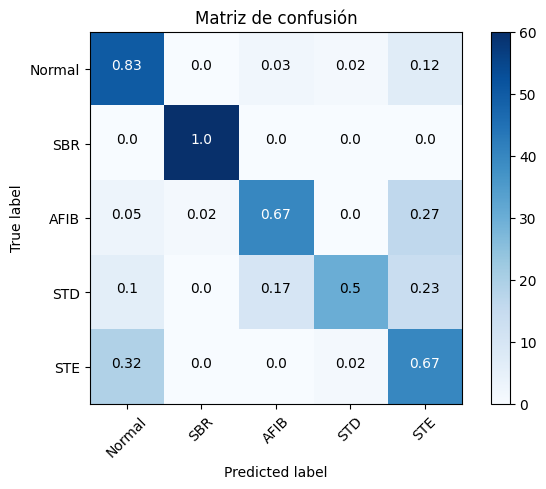

In [16]:
data_test, labels_test = load_data_test_cnn()
y_prediction = Best_Hiper_ModelCNN.predict(data_test)
print(y_prediction)
rounded_predictions=np.argmax(y_prediction,axis=1)
cm = confusion_matrix(y_true=labels_test, y_pred=rounded_predictions)
cm_plot_labels = ['Normal','SBR','AFIB','STD','STE']
ruta='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\MatricesDeConfusion\\SN\\MatrizDatosTestModeloEntrenadoSN.png'
plot_confusion_matrix(cm=cm, classes=cm_plot_labels,ruta=ruta, title='Matriz de confusión',normalize=True)

# Mejor modelo entrenado del modelo de hiperparámetros

Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
10/10 [==============================] - 0s 19ms/step
[[4.0815258e-01 9.0050483e-03 4.4083942e-04 1.0049569e-01 4.8190582e-01]
 [2.0841318e-01 2.3852792e-02 2.2876316e-03 1.5409473e-01 6.1135167e-01]
 [7.7180966e-04 4.4065189e-07 2.1459157e-02 4.4014612e-01 5.3762251e-01]
 ...
 [9.6477860e-01 1.3321781e-02 3.9135002e-09 3.3190525e-05 2.1866409e-02]
 [6.5854001e-06 3.4305954e-11 8.4703837e-13 5.3526922e-08 9.9999332e-01]
 [1.8002638e-10 3.0696068e-19 1.5423938e-20 6.7924521e-14 1.0000000e+00]]
Normalized confusion matrix
[[0.73 0.   0.12 0.   0.15]
 [0.   1.   0.   0.   0.  ]
 [0.   0.   0.85 0.   0.15]
 [0.07 0.   0.2  0.5  0.23]
 [0.38 0.   0.   0.   0.62]]


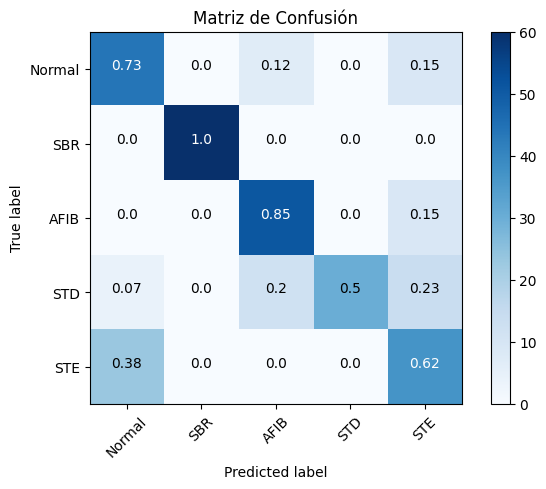

In [17]:
# cargar datos de prueba
data_test, labels_test = load_data_test_cnn()
# data_test=np.moveaxis(data_test,1,-2)

# cargar modelo previamente entrenado
model_file = 'C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\ModelosCheckpointsMejoresHiperparametros\\SN\\'
ModelCNN_best = keras.models.load_model(model_file+'mejor_modelo_CNN_SN.h5',custom_objects={"f1": f1})
# hacer la predicción
y_prediction = ModelCNN_best.predict(data_test)
print(y_prediction)
rounded_predictions=np.argmax(y_prediction,axis=1)

# obtener matriz de confusión y graficarla
cm = confusion_matrix(y_true=labels_test, y_pred=rounded_predictions)
cm_plot_labels = ['Normal','SBR','AFIB','STD','STE']
ruta='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\MatricesDeConfusion\\SN\\\MatrizDatosTestMejorModeloEntrenadoSN.png'
plot_confusion_matrix(cm=cm, classes=cm_plot_labels,ruta=ruta,title='Matriz de Confusión',normalize=True)

# Guardando datos del modelo entrenado

In [58]:
import json
#Guardando historiales
path='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\ModeloMejoresHiperparametros\\SN\\'
with open(path+'historial_Modelo_CNN_SN_final.json', 'w') as f:
    json.dump(history.history, f)

#Guardando mejor modelo
Best_Hiper_ModelCNN.save('C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\ModeloMejoresHiperparametros\\SN\\Modelo_CNN_SN_final.h5')
ModelCNN_best.save('C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\ModeloMejoresHiperparametros\\SN\\Modelo_CNN_SN_Best_final.h5')

# Modelo seleccionado

In [6]:
import json
ruta_json='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\ModelosCheckpointsOptuna\\SN\\historial_Modelo_CNN_trial'
archivoAcargar='14.json'
with open(ruta_json+archivoAcargar, 'r') as archivo_json:
    datos = json.load(archivo_json)

print(datos)

{'loss': [0.8957911729812622, 0.39848724007606506, 0.2890392541885376, 0.23034735023975372, 0.1999097764492035, 0.19128501415252686, 0.15592406690120697, 0.13572782278060913, 0.11976468563079834, 0.11660852283239365, 0.10984565317630768, 0.12899091839790344, 0.09960487484931946, 0.09021546691656113, 0.0936896875500679, 0.08255650103092194, 0.07324595004320145, 0.07407239079475403, 0.07036612182855606, 0.06221240758895874, 0.059553083032369614, 0.05770455673336983, 0.05536504089832306, 0.05324334651231766, 0.04928392544388771, 0.049890339374542236, 0.05129747465252876, 0.06414953619241714, 0.05238569900393486, 0.044166773557662964], 'accuracy': [0.7429855465888977, 0.8818771839141846, 0.9128307700157166, 0.9326010942459106, 0.9474787712097168, 0.9588617086410522, 0.959660530090332, 0.9664503335952759, 0.9702446460723877, 0.9723414778709412, 0.9772341251373291, 0.9745382070541382, 0.9780329465866089, 0.9803295135498047, 0.9830254912376404, 0.9817274212837219, 0.9857214093208313, 0.986719

In [11]:
index_max=np.argmax(datos['val_accuracy'])
print('val_accuracy:',datos['val_accuracy'][index_max]*100)

index_max=np.argmax(datos['accuracy'])
print('accuracy:',datos['accuracy'][index_max]*100)

index_max=np.argmax(datos['val_f1'])
print('val_f1:',datos['val_f1'][index_max]*100)

index_max=np.argmax(datos['f1'])
print('f1:',datos['f1'][index_max]*100)

index_max=np.argmax(datos['val_auc'])
print('val_auc:',datos['val_auc'][index_max]*100)

index_max=np.argmax(datos['auc'])
print('auc:',datos['auc'][index_max]*100)

val_accuracy: 83.99999737739563
accuracy: 99.42086935043335
val_f1: 89.00075554847717
f1: 99.43525195121765
val_auc: 93.51153373718262
auc: 99.99541640281677


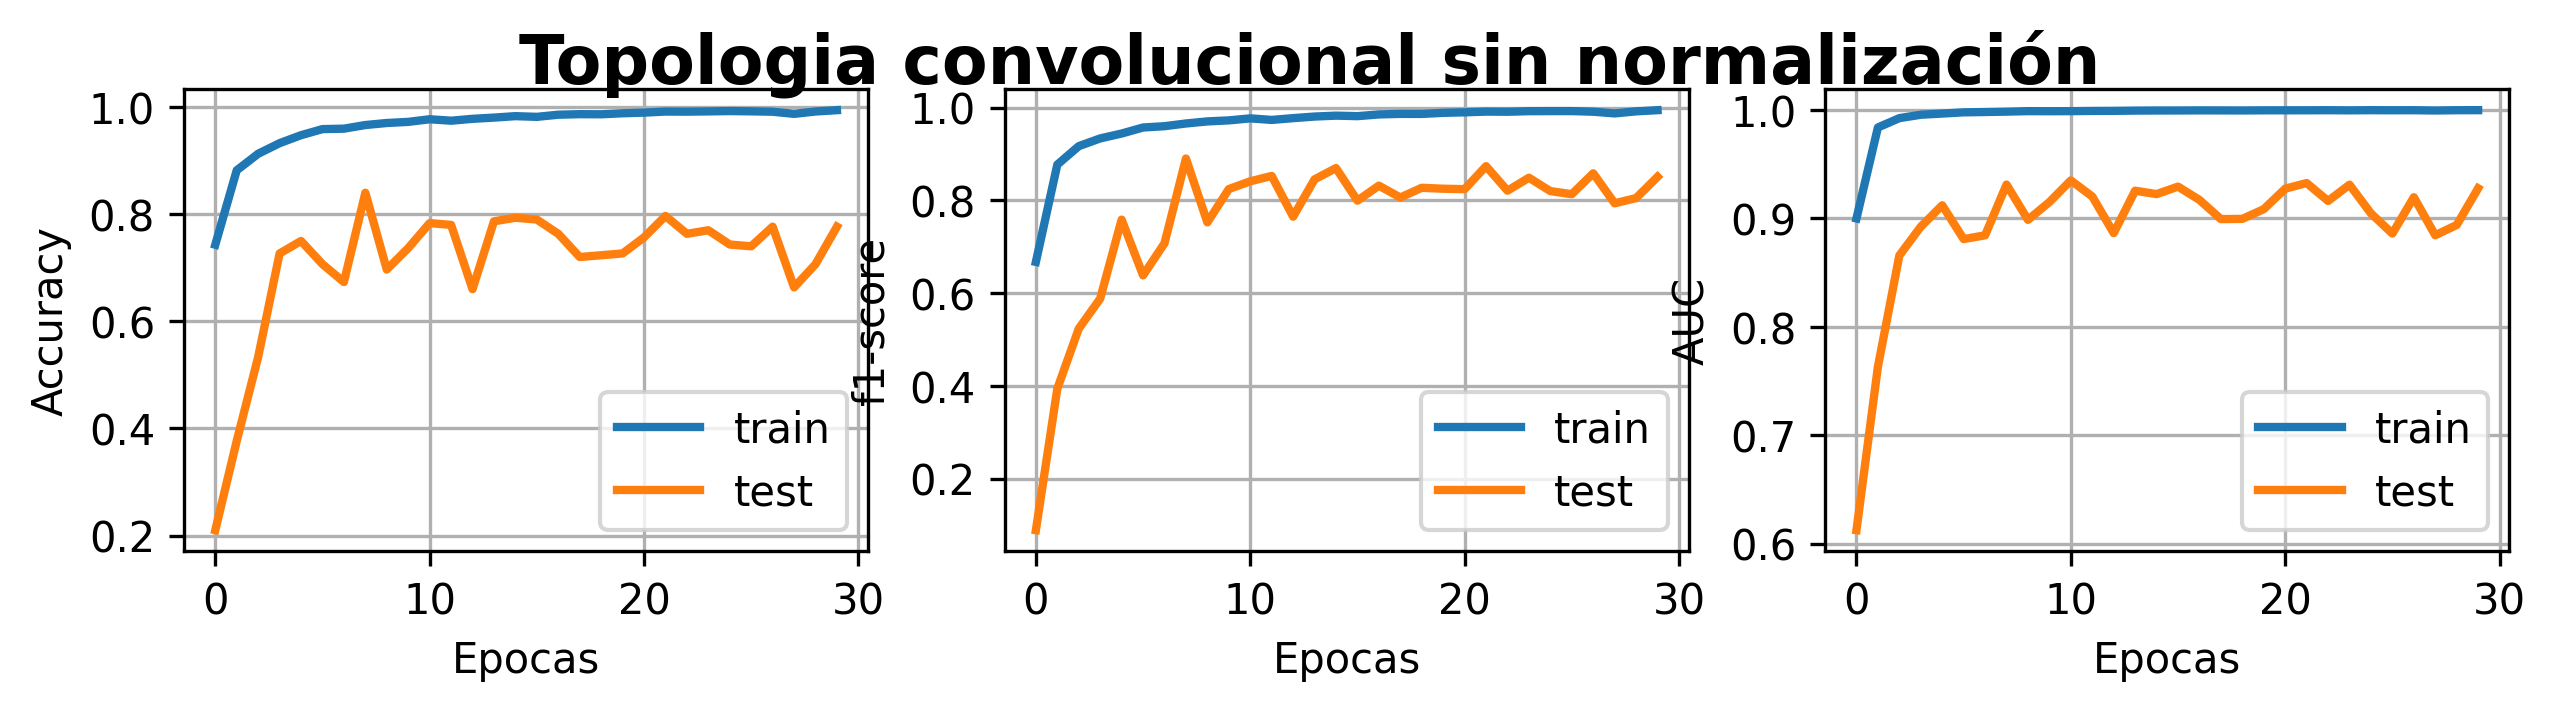

In [4]:
import matplotlib.pyplot as plt

# Configuración de la figura
fig, axs = plt.subplots(1, 3, figsize=(10, 2), dpi=300)

# Gráfica 1 - Accuracy
axs[0].plot(datos['accuracy'], linewidth=2,)
axs[0].plot(datos['val_accuracy'], linewidth=2,)
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epocas')
axs[0].legend(['train', 'test'])
axs[0].grid()

# Gráfica 2 - F1-score
axs[1].plot(datos['f1'], linewidth=2,)
axs[1].plot(datos['val_f1'], linewidth=2,)
axs[1].set_ylabel('f1-score')
axs[1].set_xlabel('Epocas')
axs[1].legend(['train', 'test'])
axs[1].grid()

# Gráfica 3 - AUC
axs[2].plot(datos['auc'], linewidth=2,)
axs[2].plot(datos['val_auc'], linewidth=2,)
axs[2].set_ylabel('AUC')
axs[2].set_xlabel('Epocas')
axs[2].legend(['train', 'test'])
axs[2].grid()

fig.suptitle('Topologia convolucional sin normalización',fontweight='bold', fontsize=16)

# Mostrar la figura
plt.savefig('C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\Imagenes\\SN\\HistorialEntrenamiento.png', dpi=300)
plt.show()


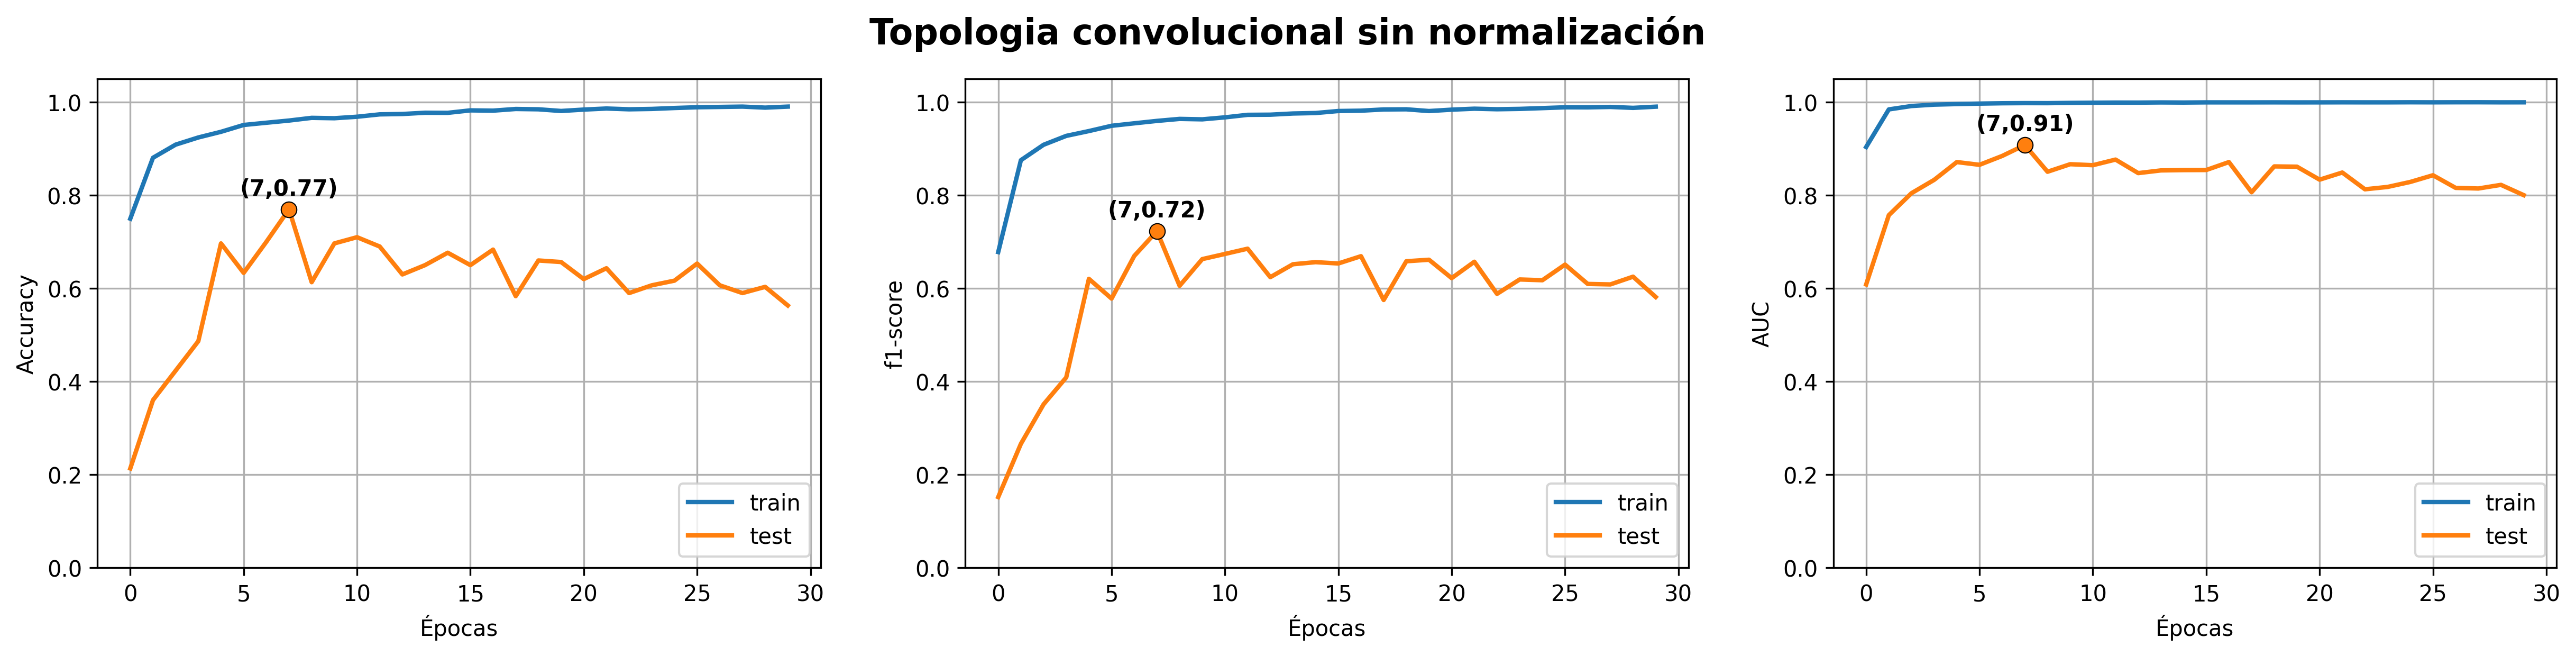

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo

# Configuración de la figura
fig, axs = plt.subplots(1, 3, figsize=(20, 4), dpi=300)

# Gráfica 1 - Accuracy
axs[0].plot(datos['accuracy'], linewidth=2,)
axs[0].plot(datos['val_accuracy'], linewidth=2,)
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Épocas')
axs[0].legend(['train', 'test'],loc='lower right')
axs[0].grid()

# Encontrar el índice y el valor máximo
index_max = np.argmax(datos['val_accuracy'])
y_max = datos['val_accuracy'][index_max]
t_max = index_max

# Plotear el punto relleno en el valor máximo y agregar la etiqueta
axs[0].scatter(t_max, y_max, color='#FF7F0E', edgecolors='k', linewidths=0.5, s=50, zorder=3)
axs[0].text(t_max, y_max+0.02,f'({t_max},{y_max:.2f})', ha='center', va='bottom', color='k',fontweight='bold')

# Gráfica 2 - F1-score
axs[1].plot(datos['f1'], linewidth=2,)
axs[1].plot(datos['val_f1'], linewidth=2,)
axs[1].set_ylabel('f1-score')
axs[1].set_xlabel('Épocas')
axs[1].legend(['train', 'test'],loc='lower right')
axs[1].grid()

# Encontrar el índice y el valor máximo
index_max = np.argmax(datos['val_f1'])
y_max = datos['val_f1'][index_max]
t_max = index_max

# Plotear el punto relleno en el valor máximo y agregar la etiqueta
axs[1].scatter(t_max, y_max, color='#FF7F0E', edgecolors='k', linewidths=0.5, s=50, zorder=3)
axs[1].text(t_max, y_max+0.02, f'({t_max},{y_max:.2f})', ha='center', va='bottom', color='k',fontweight='bold')

# Gráfica 3 - AUC
axs[2].plot(datos['auc'], linewidth=2,)
axs[2].plot(datos['val_auc'], linewidth=2,color='#FF7F0E')
axs[2].set_ylabel('AUC')
axs[2].set_xlabel('Épocas')
axs[2].legend(['train', 'test'],loc='lower right')
axs[2].grid()

# Encontrar el índice y el valor máximo
index_max = np.argmax(datos['val_auc'])
y_max = datos['val_auc'][index_max]
t_max = index_max

# Plotear el punto relleno en el valor máximo y agregar la etiqueta
axs[2].scatter(t_max, y_max, color='#FF7F0E', edgecolors='k', linewidths=0.5, s=50, zorder=3)
axs[2].text(t_max, y_max+0.02, f'({t_max},{y_max:.2f})', ha='center', va='bottom', color='k',fontweight='bold')

# Establecer el mismo rango máximo en los tres ejes Y
y_max = 1.05
axs[0].set_ylim([0, y_max])
axs[1].set_ylim([0, y_max])
axs[2].set_ylim([0, y_max])

fig.suptitle('Topologia convolucional sin normalización',fontweight='bold', fontsize=16)

# Mostrar la figura
plt.savefig('C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\Imagenes\\SN\\HistorialEntrenamiento.png', dpi=300)
plt.show()

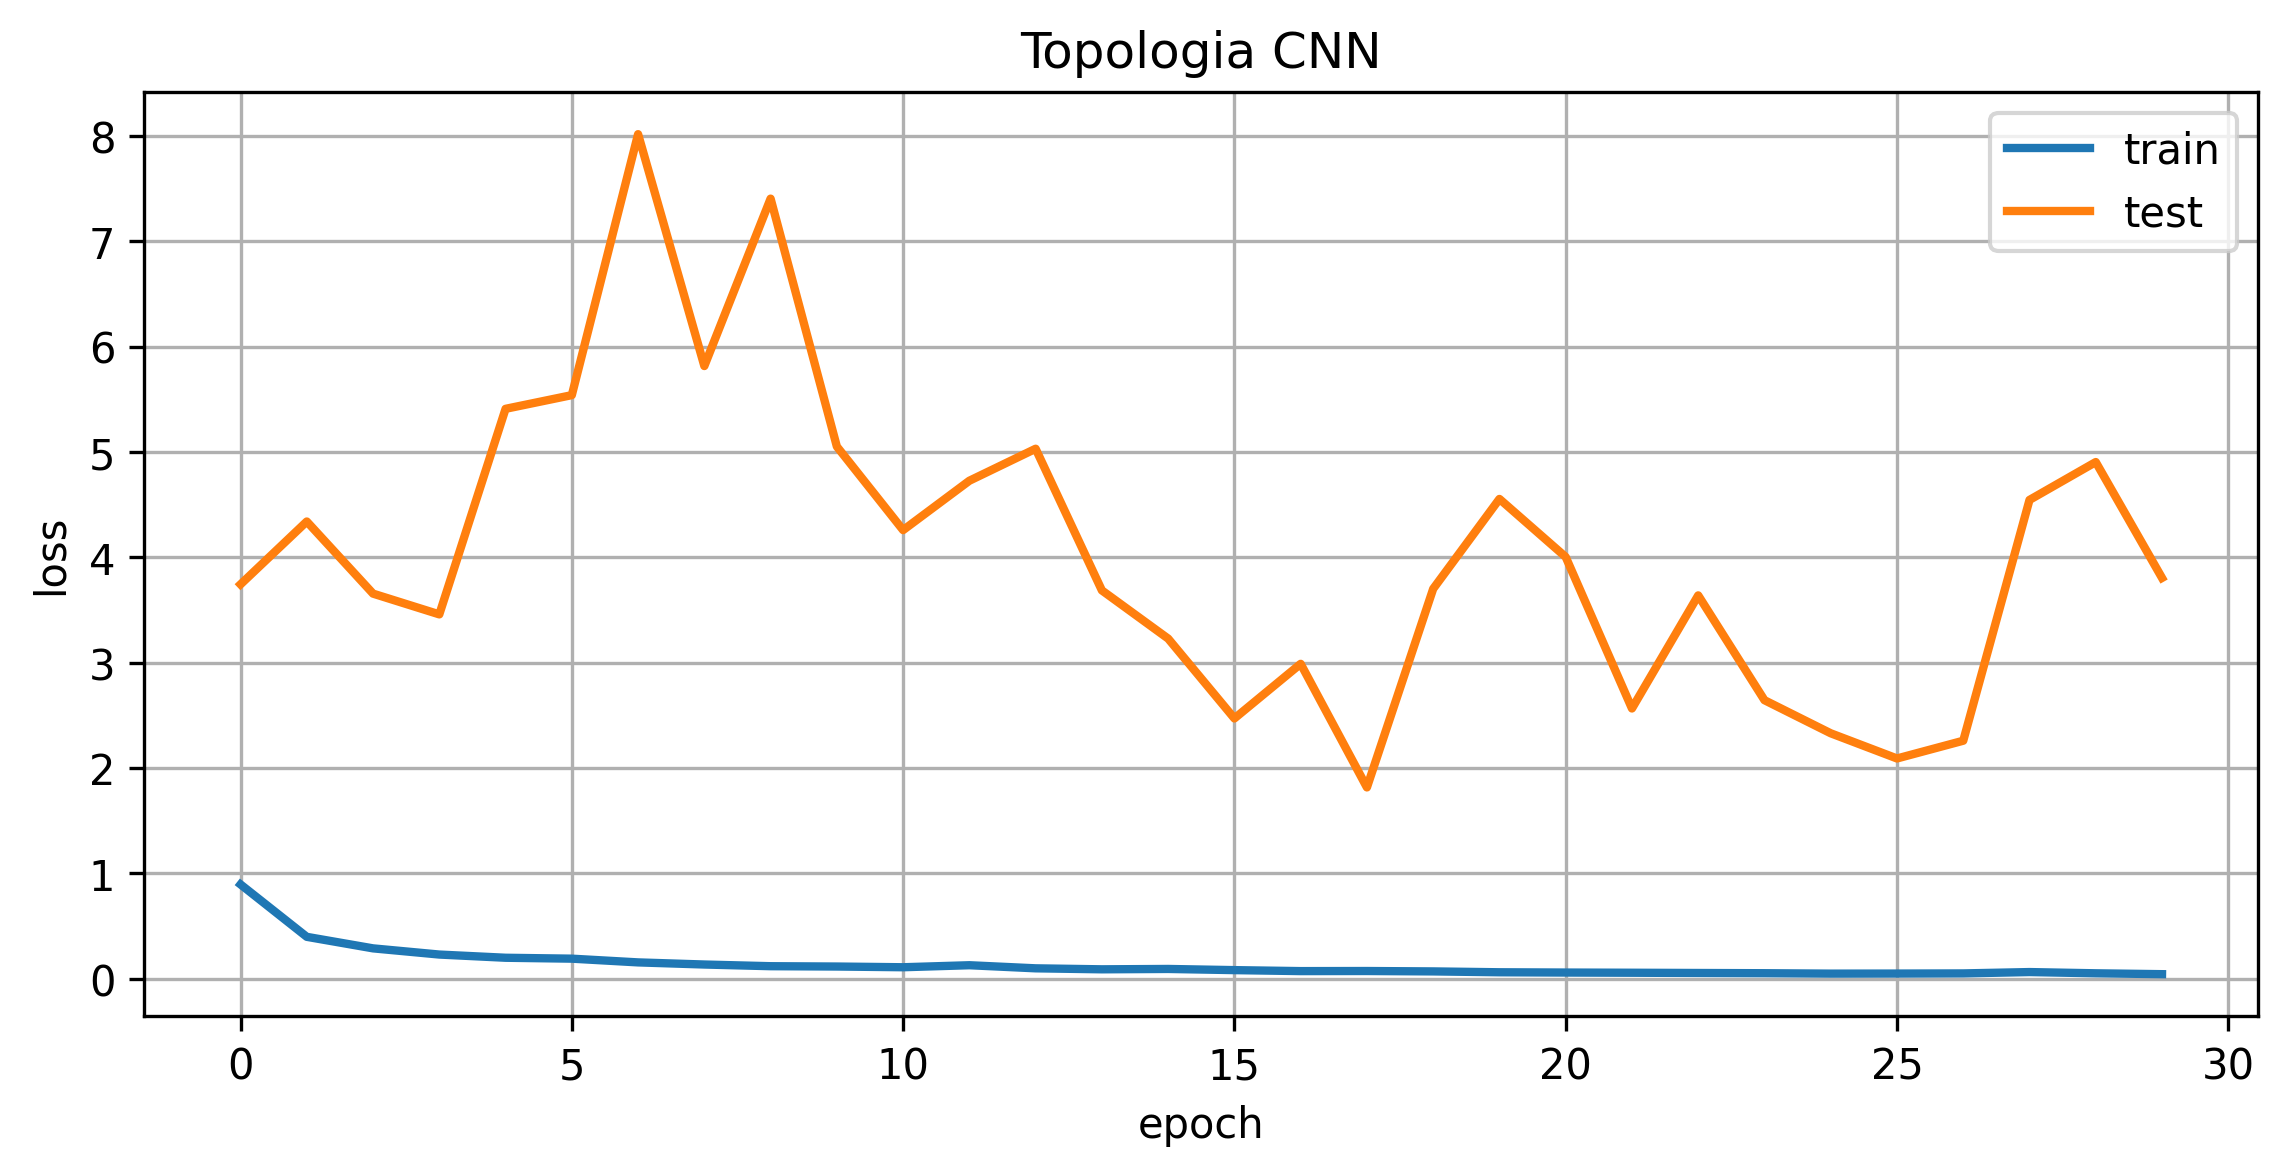

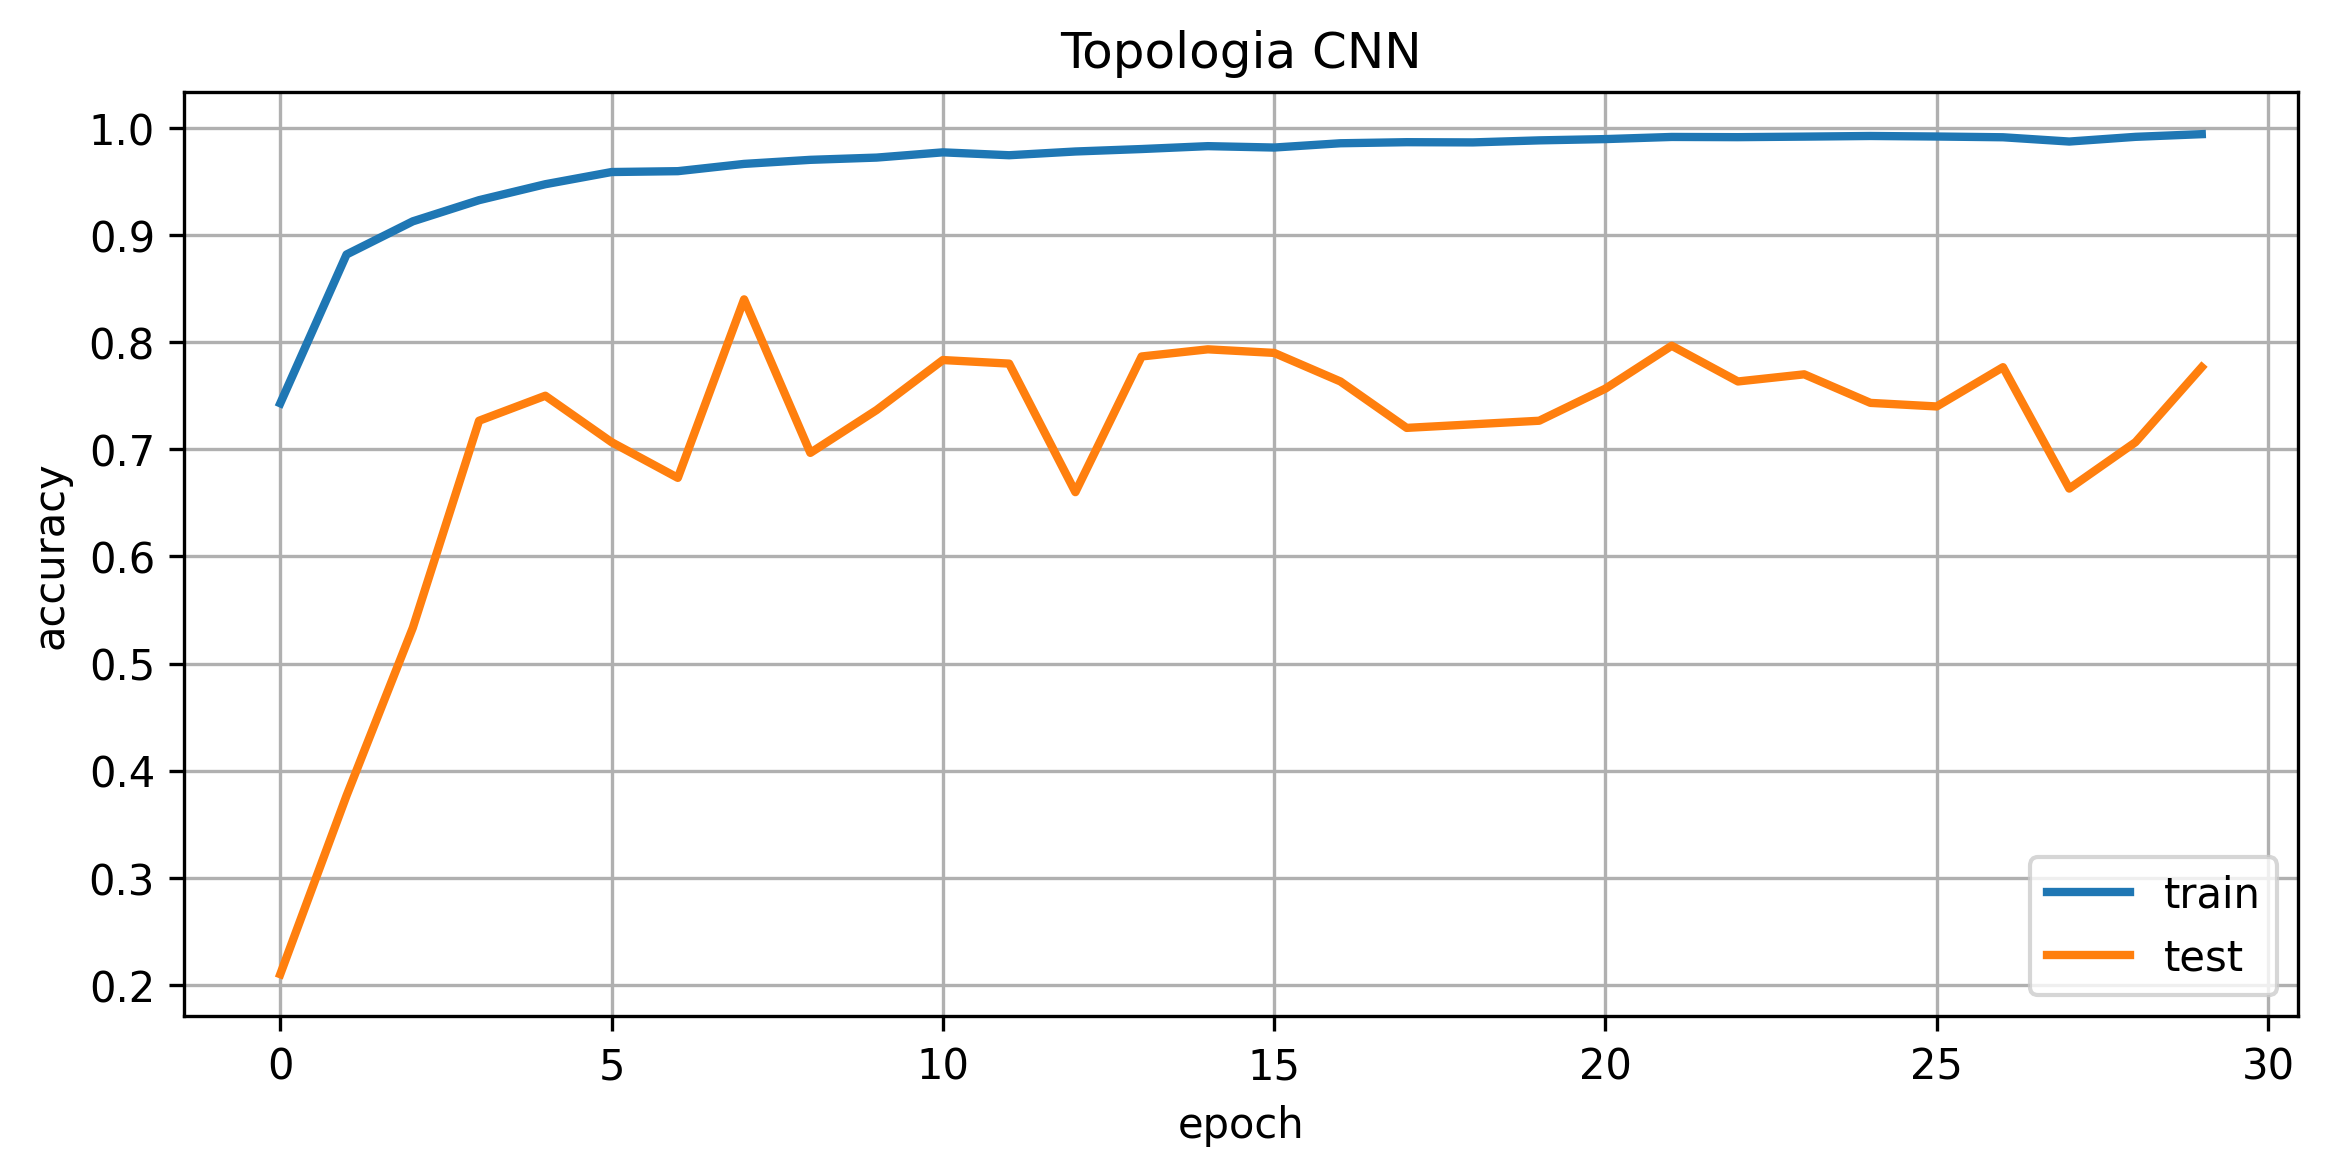

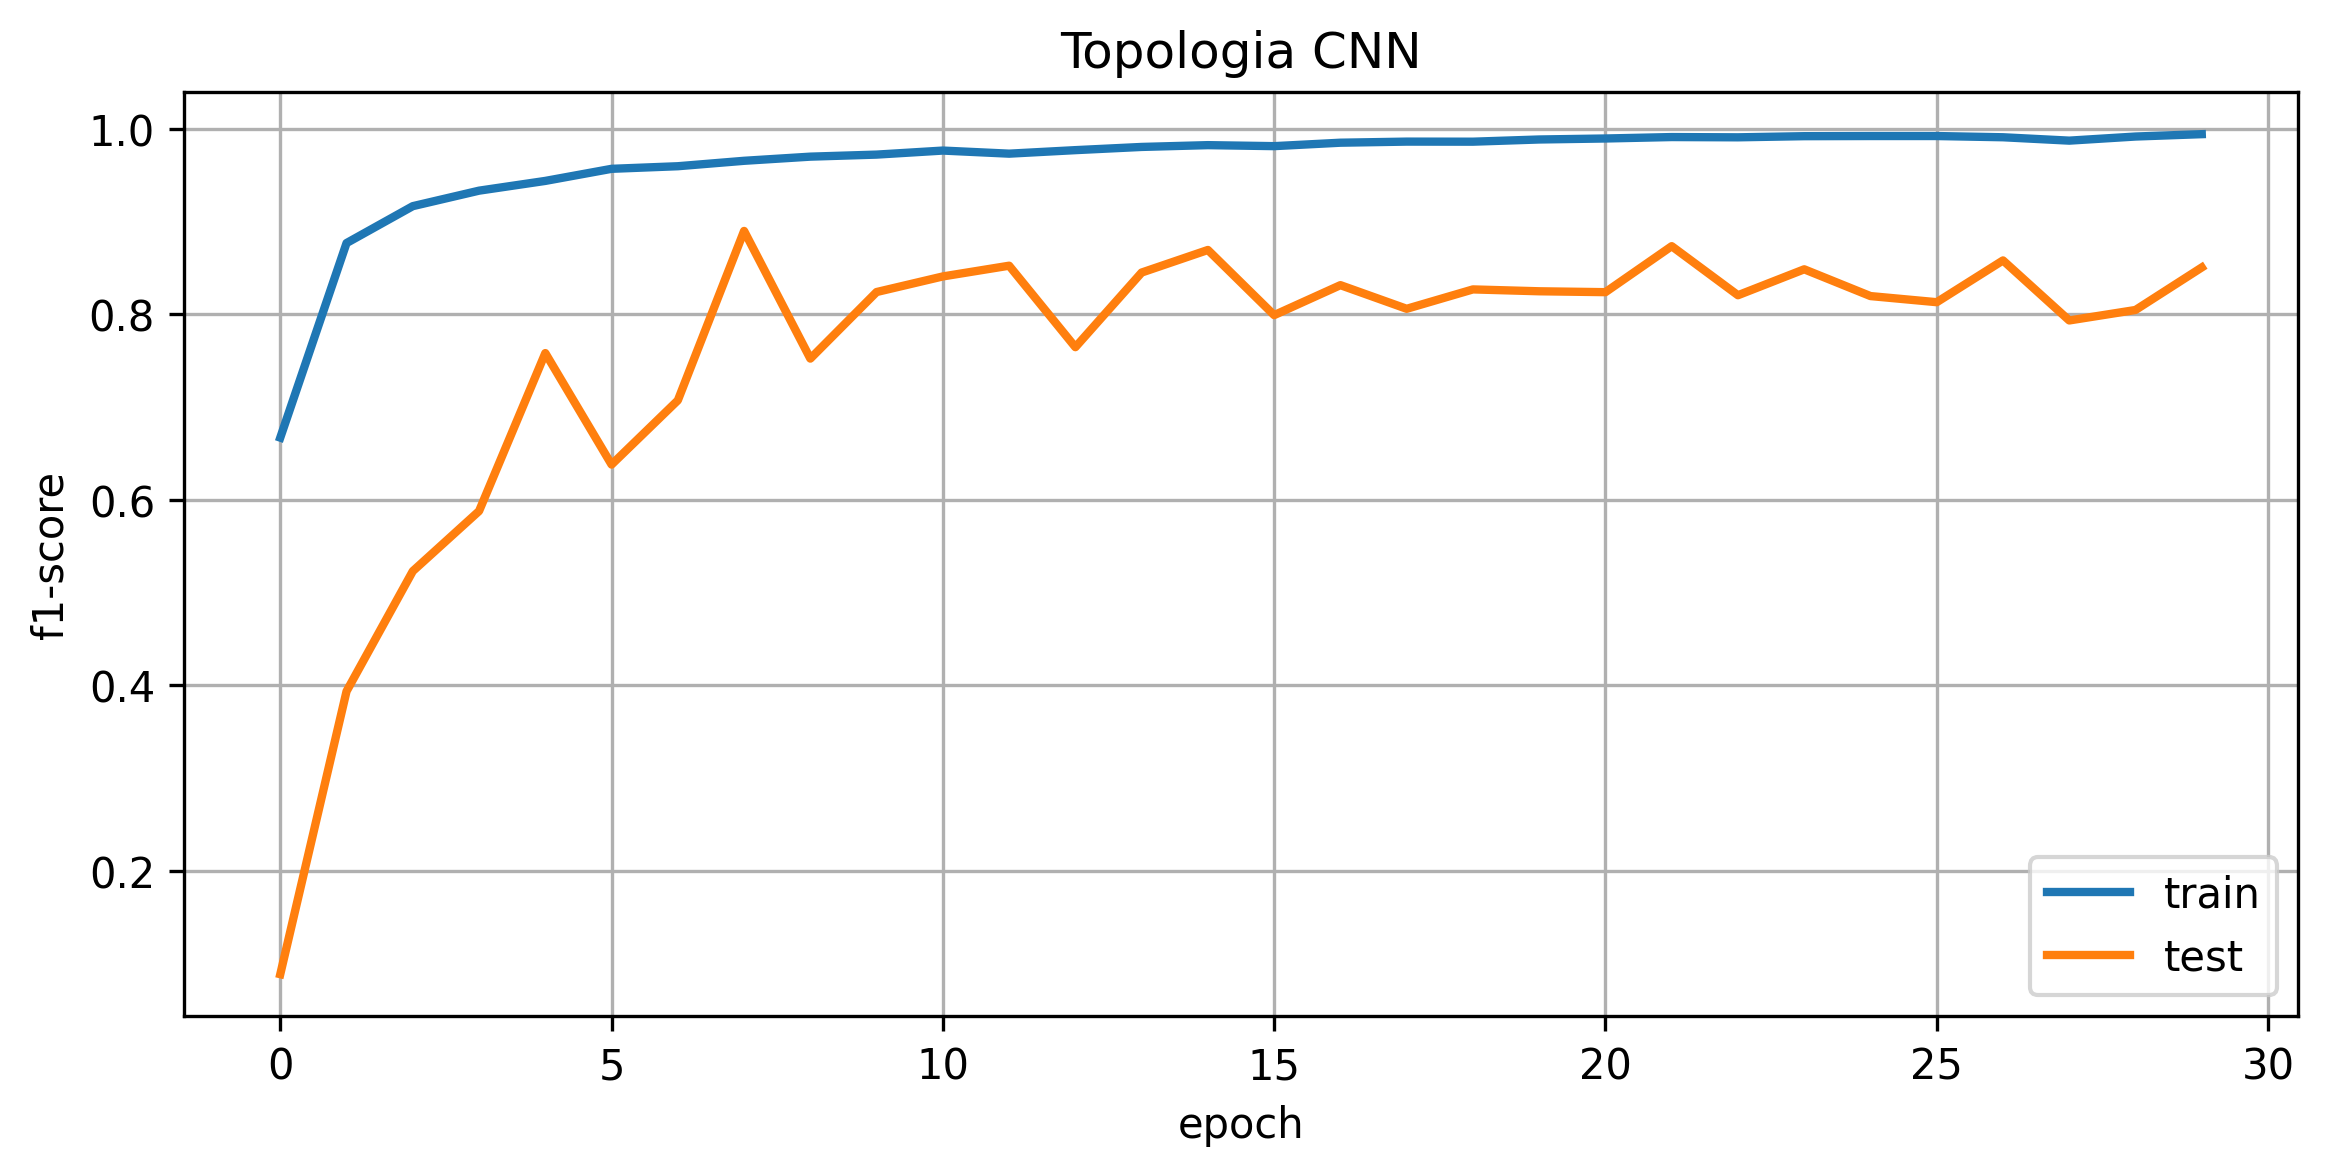

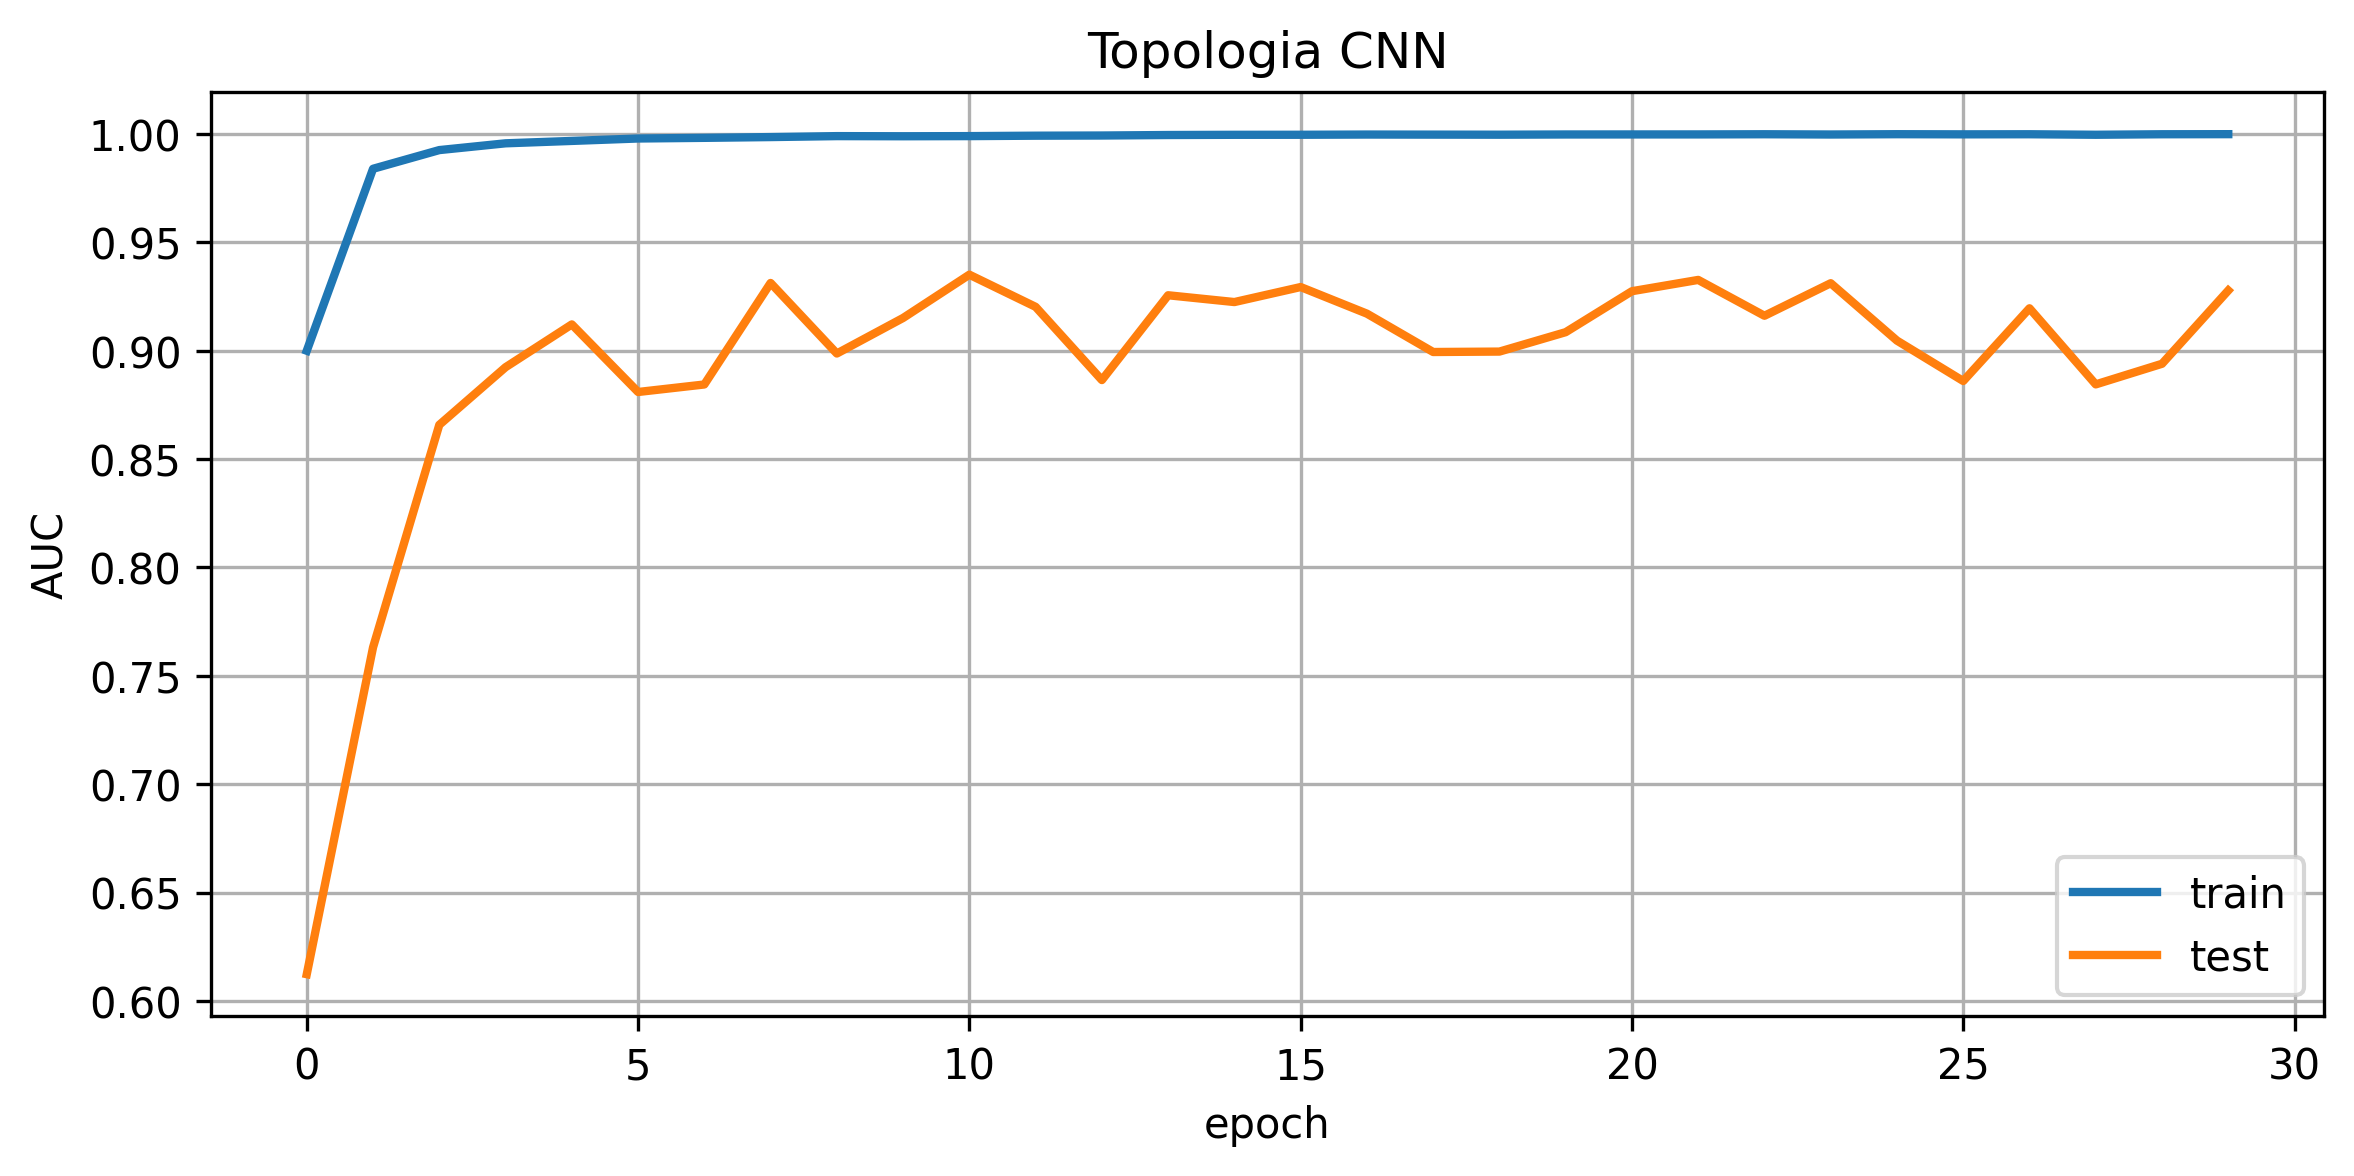

In [10]:
plt.figure(figsize=(20, 4),dpi=300)
plt.subplot(1,2,2)
plt.plot(datos['accuracy'], linewidth=2,)
plt.plot(datos['val_accuracy'], linewidth=2,)
plt.title('Topologia CNN')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'])
plt.grid()
plt.show()

plt.figure(figsize=(20, 4),dpi=300)
plt.subplot(1,2,2)
plt.plot(datos['f1'], linewidth=2,)
plt.plot(datos['val_f1'], linewidth=2,)
plt.title('Topologia CNN')
plt.ylabel('f1-score')
plt.xlabel('epoch')
plt.legend(['train','test'])
plt.grid()
plt.show()

plt.figure(figsize=(20, 4),dpi=300)
plt.subplot(1,2,2)
plt.plot(datos['auc'], linewidth=2,)
plt.plot(datos['val_auc'], linewidth=2,)
plt.title('Topologia CNN')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train','test'])
plt.grid()
plt.show()

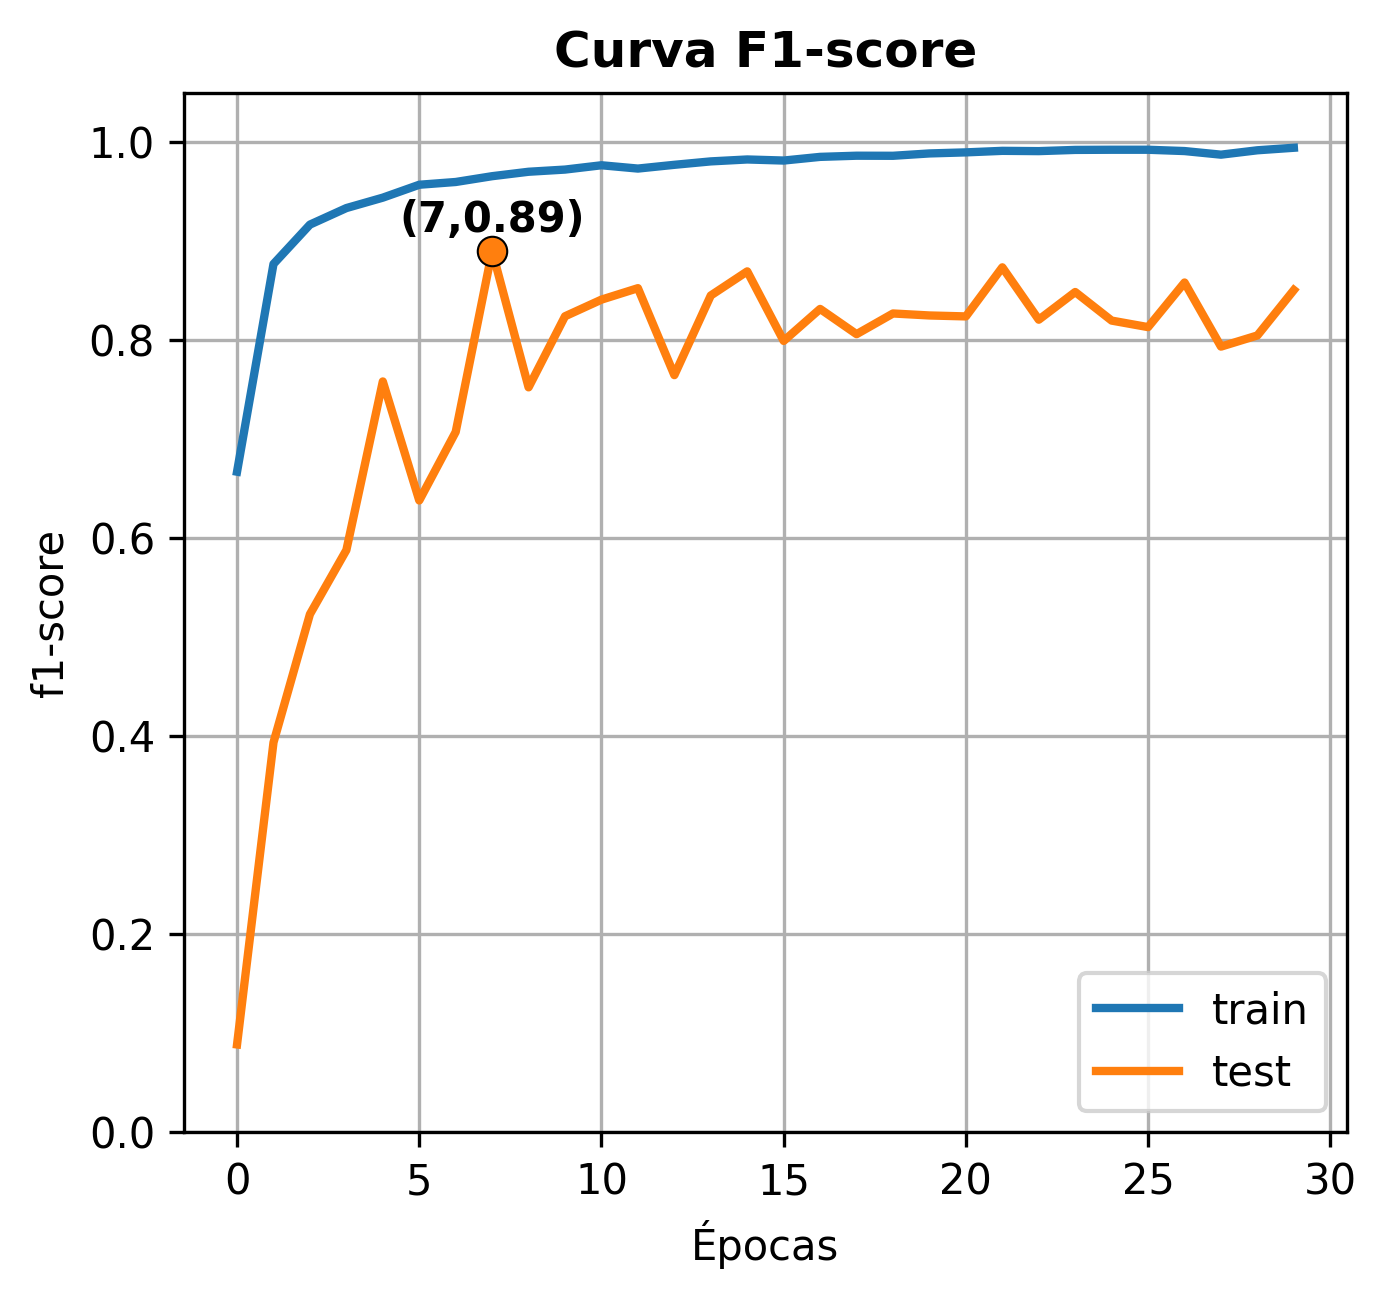

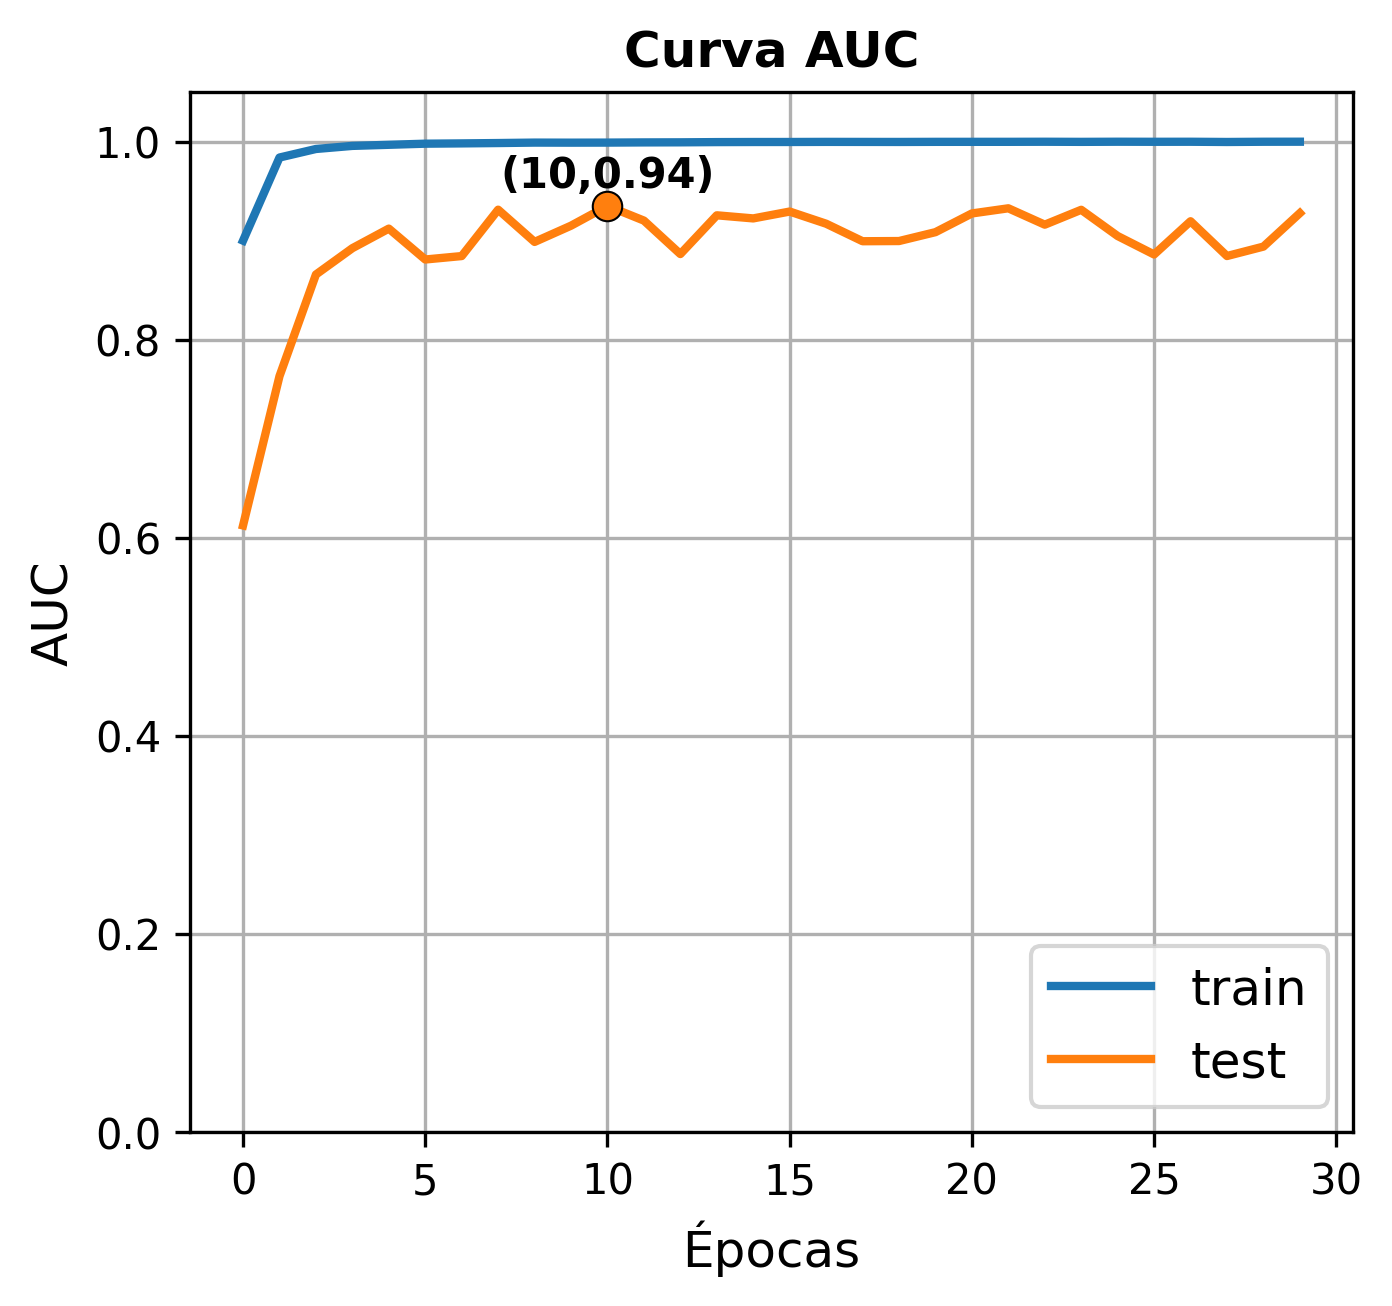

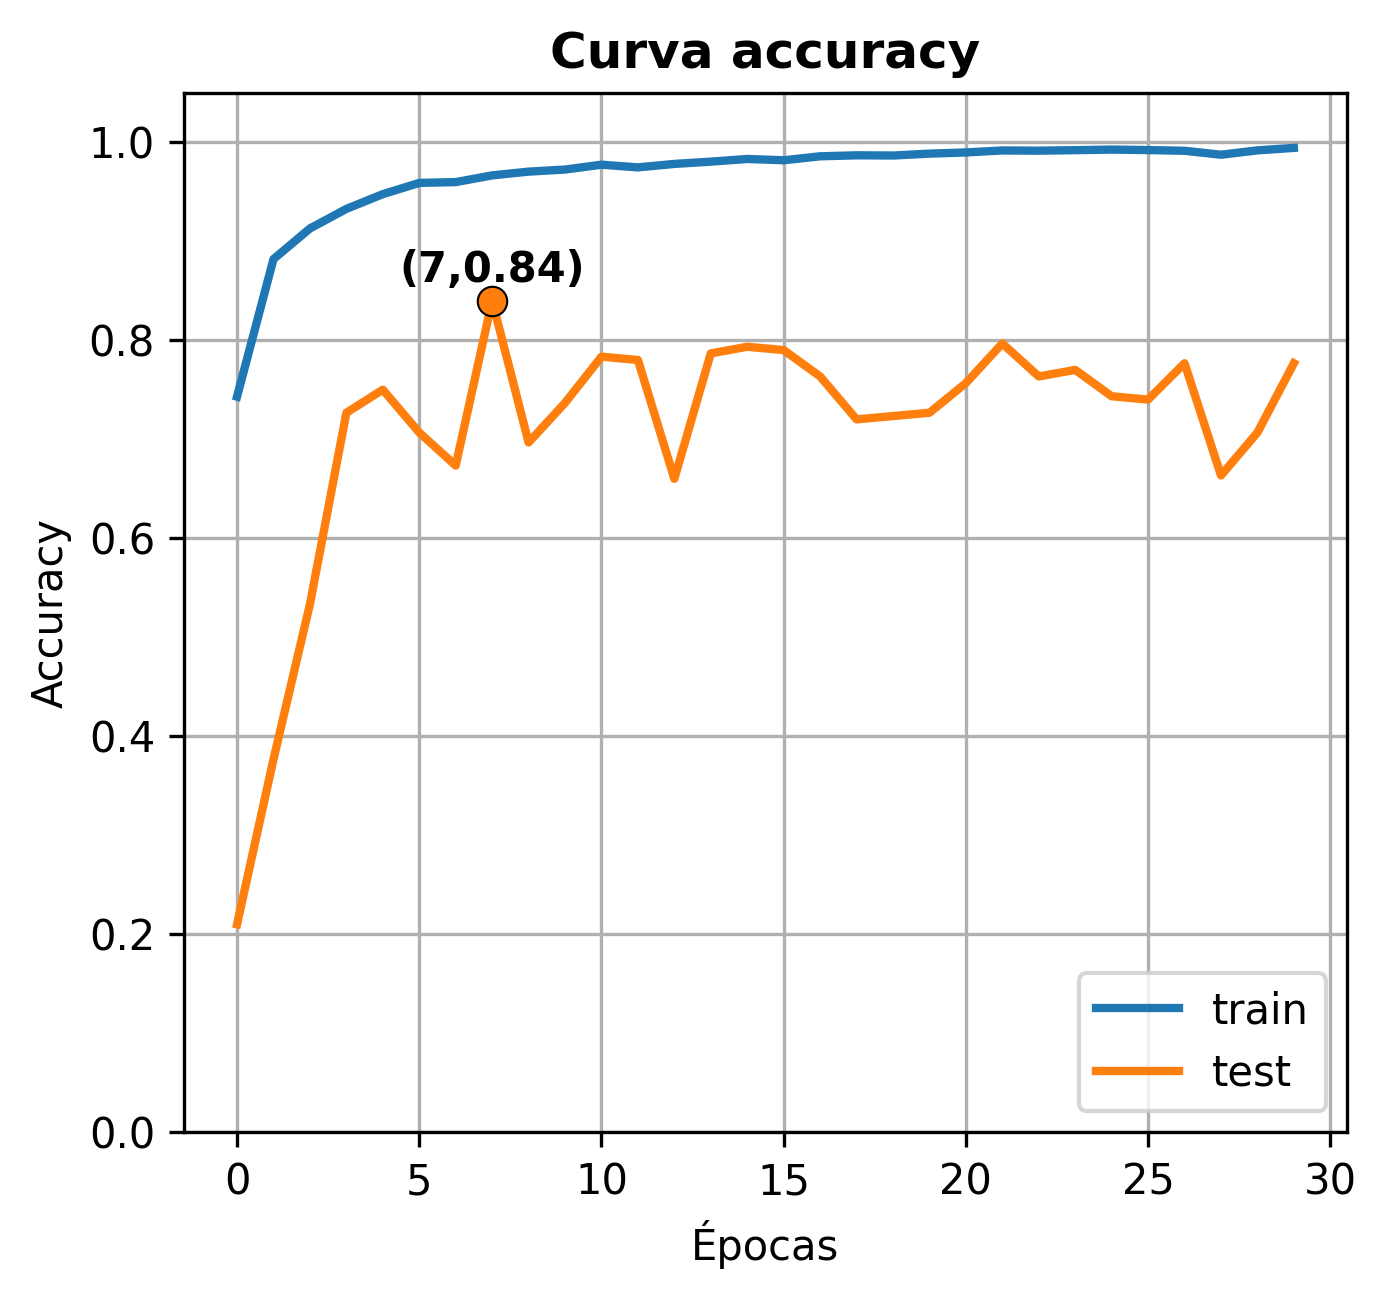

In [5]:
# Crear una nueva figura con solo la subfigura 3
fig2, ax2 = plt.subplots(figsize=(5,4.5), dpi=300)
ax2.plot(datos['f1'], linewidth=2,)
ax2.plot(datos['val_f1'], linewidth=2,color='#FF7F0E')
ax2.set_ylabel('f1-score')
ax2.set_xlabel('Épocas')
ax2.legend(['train', 'test'],loc='lower right')
ax2.grid()

# Encontrar el índice y el valor máximo
index_max = np.argmax(datos['val_f1'])
y_max = datos['val_f1'][index_max]
t_max = index_max

# Plotear el punto relleno en el valor máximo y agregar la etiqueta
ax2.scatter(t_max, y_max, color='#FF7F0E', edgecolors='k', linewidths=0.5, s=50, zorder=3)
ax2.text(t_max, y_max+0.01, f'({t_max},{y_max:.2f})', ha='center', va='bottom', color='k',fontweight='bold')

# Establecer el rango máximo en el eje Y
y_max = 1.05
ax2.set_ylim([0, y_max])

plt.title('Curva F1-score',fontweight='bold')

# Guardar la figura en un archivo separado
plt.savefig('C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\Imagenes\\SN\\subfigura2.png', dpi=300)

# Mostrar la figura
plt.show()



# Crear una nueva figura con solo la subfigura 3
fig2, ax2 = plt.subplots(figsize=(5,4.5), dpi=300)
ax2.plot(datos['auc'], linewidth=2,)
ax2.plot(datos['val_auc'], linewidth=2,color='#FF7F0E')
ax2.set_ylabel('AUC',fontsize=12)
ax2.set_xlabel('Épocas',fontsize=12)
ax2.legend(['train', 'test'],loc='lower right',fontsize=12)
ax2.grid()

# Encontrar el índice y el valor máximo
index_max = np.argmax(datos['val_auc'])
y_max = datos['val_auc'][index_max]
t_max = index_max

# Plotear el punto relleno en el valor máximo y agregar la etiqueta
ax2.scatter(t_max, y_max, color='#FF7F0E', edgecolors='k', linewidths=0.5, s=50, zorder=3)
ax2.text(t_max, y_max+0.01, f'({t_max},{y_max:.2f})', ha='center', va='bottom', color='k',fontweight='bold')

# Establecer el rango máximo en el eje Y
y_max = 1.05
ax2.set_ylim([0, y_max])

plt.title('Curva AUC',fontweight='bold')

# Guardar la figura en un archivo separado
plt.savefig('C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\Imagenes\\SN\\subfigura3.png', dpi=300)

# Mostrar la figura
plt.show()

# Crear una nueva figura con solo la subfigura 3
fig2, ax2 = plt.subplots(figsize=(5,4.5), dpi=300)
ax2.plot(datos['accuracy'], linewidth=2,)
ax2.plot(datos['val_accuracy'], linewidth=2,color='#FF7F0E')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Épocas')
ax2.legend(['train', 'test'],loc='lower right')
ax2.grid()

# Encontrar el índice y el valor máximo
index_max = np.argmax(datos['val_accuracy'])
y_max = datos['val_accuracy'][index_max]
t_max = index_max

# Plotear el punto relleno en el valor máximo y agregar la etiqueta
ax2.scatter(t_max, y_max, color='#FF7F0E', edgecolors='k', linewidths=0.5, s=50, zorder=3)
ax2.text(t_max, y_max+0.01, f'({t_max},{y_max:.2f})', ha='center', va='bottom', color='k',fontweight='bold')

# Establecer el rango máximo en el eje Y
y_max = 1.05
ax2.set_ylim([0, y_max])

plt.title('Curva accuracy',fontweight='bold')

# Guardar la figura en un archivo separado
plt.savefig('C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\Imagenes\\SN\\subfigura1.png', dpi=300)

# Mostrar la figura
plt.show()